In [1]:
import numpy as np
import pandas as pd
from astropy.cosmology import Planck13 as cosmo
from astropy.io import fits
import fsps
from matplotlib.gridspec import GridSpec
from spec_tools import Source_present, Scale_model, Oldest_galaxy, Sig_int,Likelihood_contours, Median_w_Error_cont
from spec_exam import Gen_spec
from sim_engine import *
from spec_stats import Highest_density_region
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, interp2d
from glob import glob
import seaborn as sea
import os
from grizli import multifit
from grizli import model
from C_full_fit import Gen_spec2, Chi_Squared
from C_sim_test import Gen_sim, F_lam_per_M

import dynesty
from dynesty import plotting as dyplot
from dynesty.utils import quantile as _quantile
from scipy.ndimage import gaussian_filter as norm_kde

import rpy2
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
R = robjects.r
pandas2ri.activate()

from time import time
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({'xtick.direct'
               'ion': 'in','xtick.top':True,'xtick.minor.visible': True,
               'ytick.direction': "in",'ytick.right': True,'ytick.minor.visible': True})
cmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.0, as_cmap=True)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

### set home for files
hpath = os.environ['HOME'] + '/'

if hpath == '/Users/Vince.ec/':
    dpath = '/Volumes/Vince_research/Data/' 
    
else:
    dpath = hpath + 'Data/' 

In [19]:
sim1 = Gen_spec('GND', 21156, 1.25257,
               g102_lims=[8300, 11288], g141_lims=[11288, 16500],mdl_err = True,
            phot_errterm = 0.0, decontam = False) 

sim2 = Gen_spec('GND', 21156, 1.25257,
               g102_lims=[8300, 11288], g141_lims=[11288, 16500],mdl_err = False,
            phot_errterm = 0.0, decontam = False) 

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3423: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3423: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2


In [8]:
specz = 1.25

In [4]:
u = 0.0
lbt = []
for i in range(10):
    u+=0.1 * i
    lbt.append(np.round(u,1))
print(lbt)
print(np.round(u + 0.1 * (i+1),1))

[0.0, 0.1, 0.3, 0.6, 1.0, 1.5, 2.1, 2.8, 3.6, 4.5]
5.5


In [5]:
def Time_bins(agelim, bins):
    u = 0.0
    lbt = []
    for i in range(bins):
        u+=0.1 * i
        lbt.append(np.round(u,1))
    
    return np.array(agelim  - lbt / np.round(u + 0.1 * (i+1),1) * agelim)[::-1]

LBT = Time_bins(Oldest_galaxy(1.25),10)
print(LBT)

[0.90396774 1.7175387  2.44071289 3.0734903  3.61587094 4.06785481
 4.4294419  4.70063222 4.88142577 4.97182254]


In [6]:
LBT

array([0.90396774, 1.7175387 , 2.44071289, 3.0734903 , 3.61587094,
       4.06785481, 4.4294419 , 4.70063222, 4.88142577, 4.97182254])

In [7]:
sp = fsps.StellarPopulation(imf_type = 2, tpagb_norm_type=0, zcontinuous = 3, sfh = 3, dust_type = 1)
sp.params['dust2'] =0.2
sp.params['dust1'] =0.2

tab_sfh = np.array([0.7, 0.8, 0.5, 0.01, 0.01, 0.001, 0.00001, 0.0002, 0.002, 0.0001])
tab_Z = np.array([0.2, 0.8, 1.0, 1.0, 0.8, 1.1, 0.7, 0.8, 0.8, 0.8])*0.019


sp.set_tabular_sfh(LBT,tab_sfh,
                   Z = tab_Z )

wave1, flux1 = sp.get_spectrum(tage = 3.5, peraa = True)

mass_perc1 = sp.stellar_mass


In [8]:
sp = fsps.StellarPopulation(imf_type = 2, tpagb_norm_type=0, zcontinuous = 1, logzsol = np.log10(1), sfh = 4, tau=0.1, dust_type = 1)
sp.params['dust2'] =0.2
sp.params['dust1'] =0.2
sp.params['tau'] =0.3
sp.params['logzsol'] = np.log10(0.8)

wave2, flux2 = sp.get_spectrum(tage = 3.5, peraa = True)

mass_perc2 = sp.stellar_mass

In [9]:
def get_50(LBT, md,age):
    hrtime = np.round(np.arange(0,LBT[-1],0.001),2)
    dt = 0.001   
    mass = np.zeros(len(hrtime))
    mbu = 0
    u = 0
    for i in range(len(hrtime)):
        if hrtime[i] > LBT[u]:
            u+=1
        mass[i] = mbu
        mbu += md[u] * dt

    mass = mass[hrtime < age]
    hrtime = hrtime[hrtime < age]
    print(mass[-1])

    return interp1d(mass,hrtime)(0.5), hrtime, mass

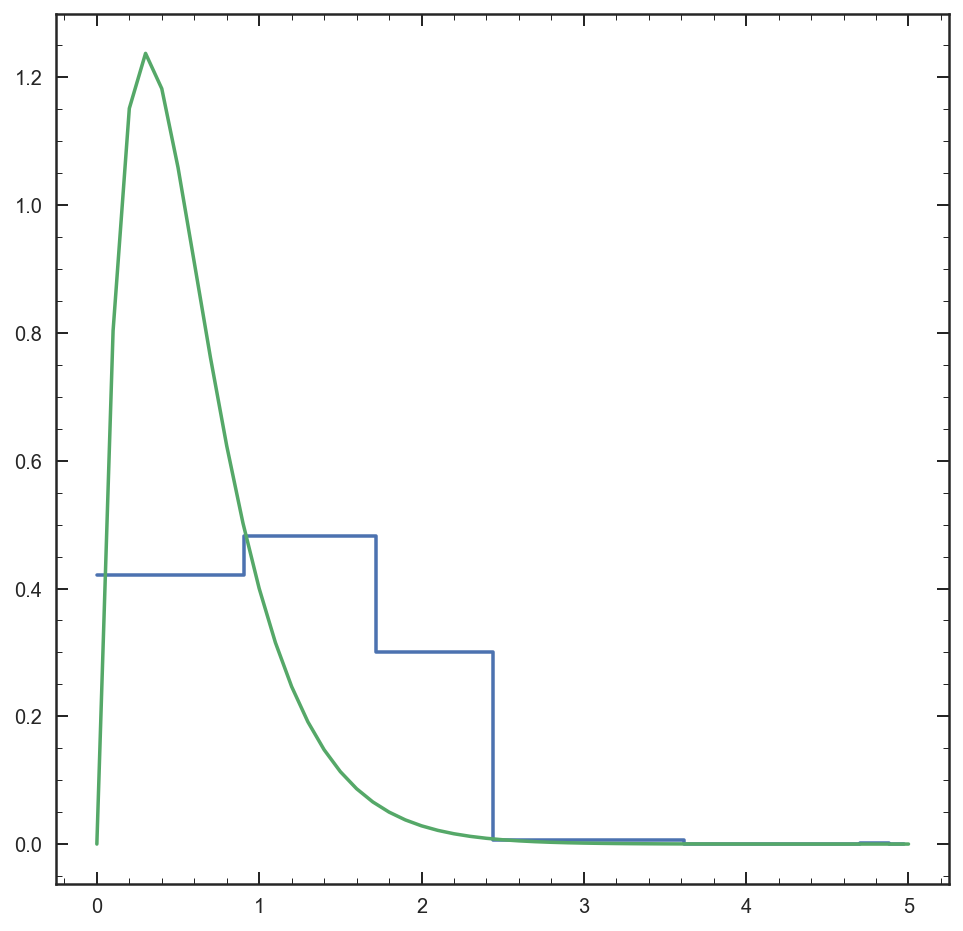

In [13]:
t= np.arange(0,Oldest_galaxy(1.25)+.1,.1)

sfh = t * np.exp(-t / 0.3)

sfh /= np.trapz(sfh,t)
tabsfh = tab_sfh / 1.6594356099999374

plt.figure(figsize=[8,8])
plt.step(np.append(0,LBT), np.append(tabsfh[0], tabsfh))

plt.plot(t,sfh)


In [10]:
D_l = cosmo.luminosity_distance(specz).value # in Mpc
conv = 3.086E24
lsol_to_fsol = 3.839E33

mass_transform = (10**11 / mass_perc1) * lsol_to_fsol / (4 * np.pi * (D_l*conv)**2)



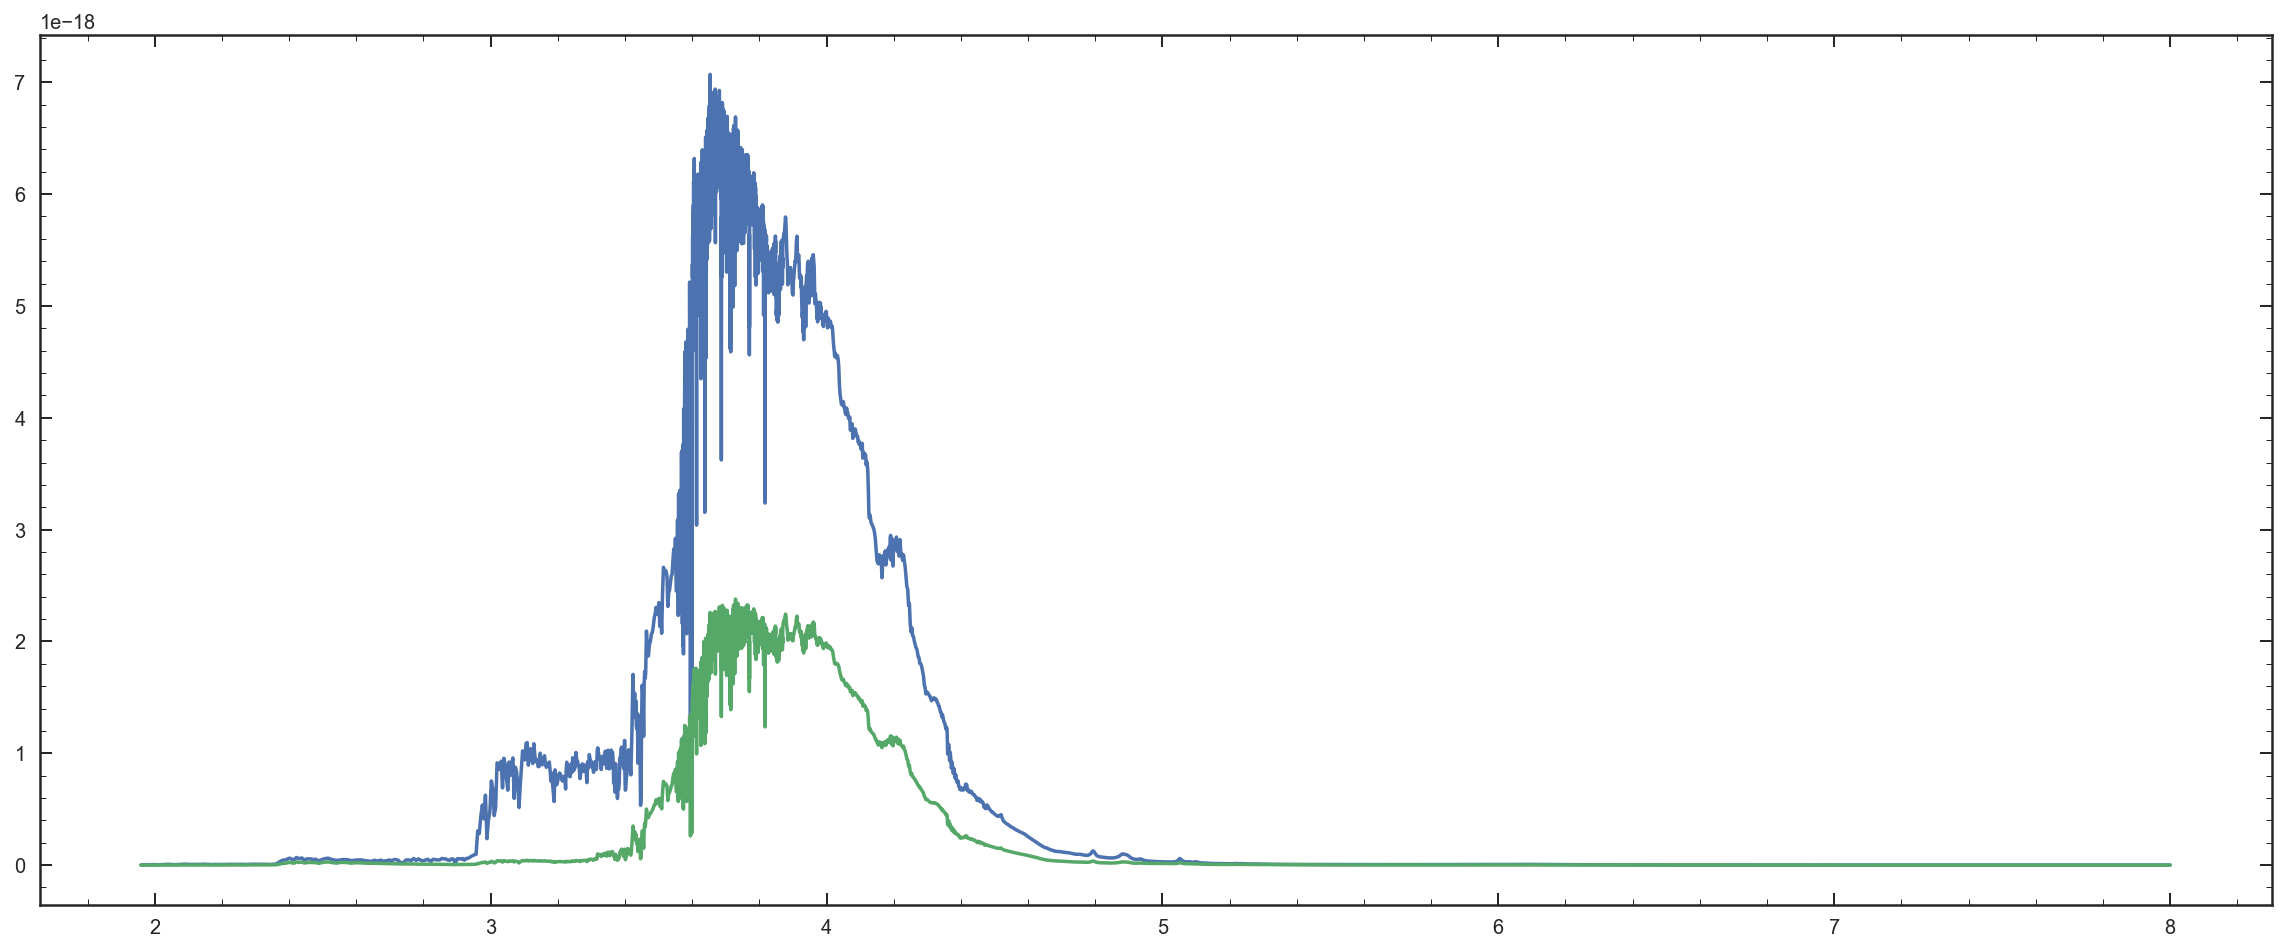

In [11]:
plt.figure(figsize=[20,8])

plt.plot(np.log10(wave1), flux1 * mass_transform)
plt.plot(np.log10(wave2), flux2 * 10**11* lsol_to_fsol / (4 * np.pi * (D_l*conv)**2))

# plt.xlim(np.log10(3000),np.log10(8000))

In [20]:
sim1.Make_sim(wave1, flux1 * mass_transform, specz)
sim2.Make_sim(wave2, flux2 * 10**11* lsol_to_fsol / (4 * np.pi * (D_l*conv)**2), specz, perturb = False)

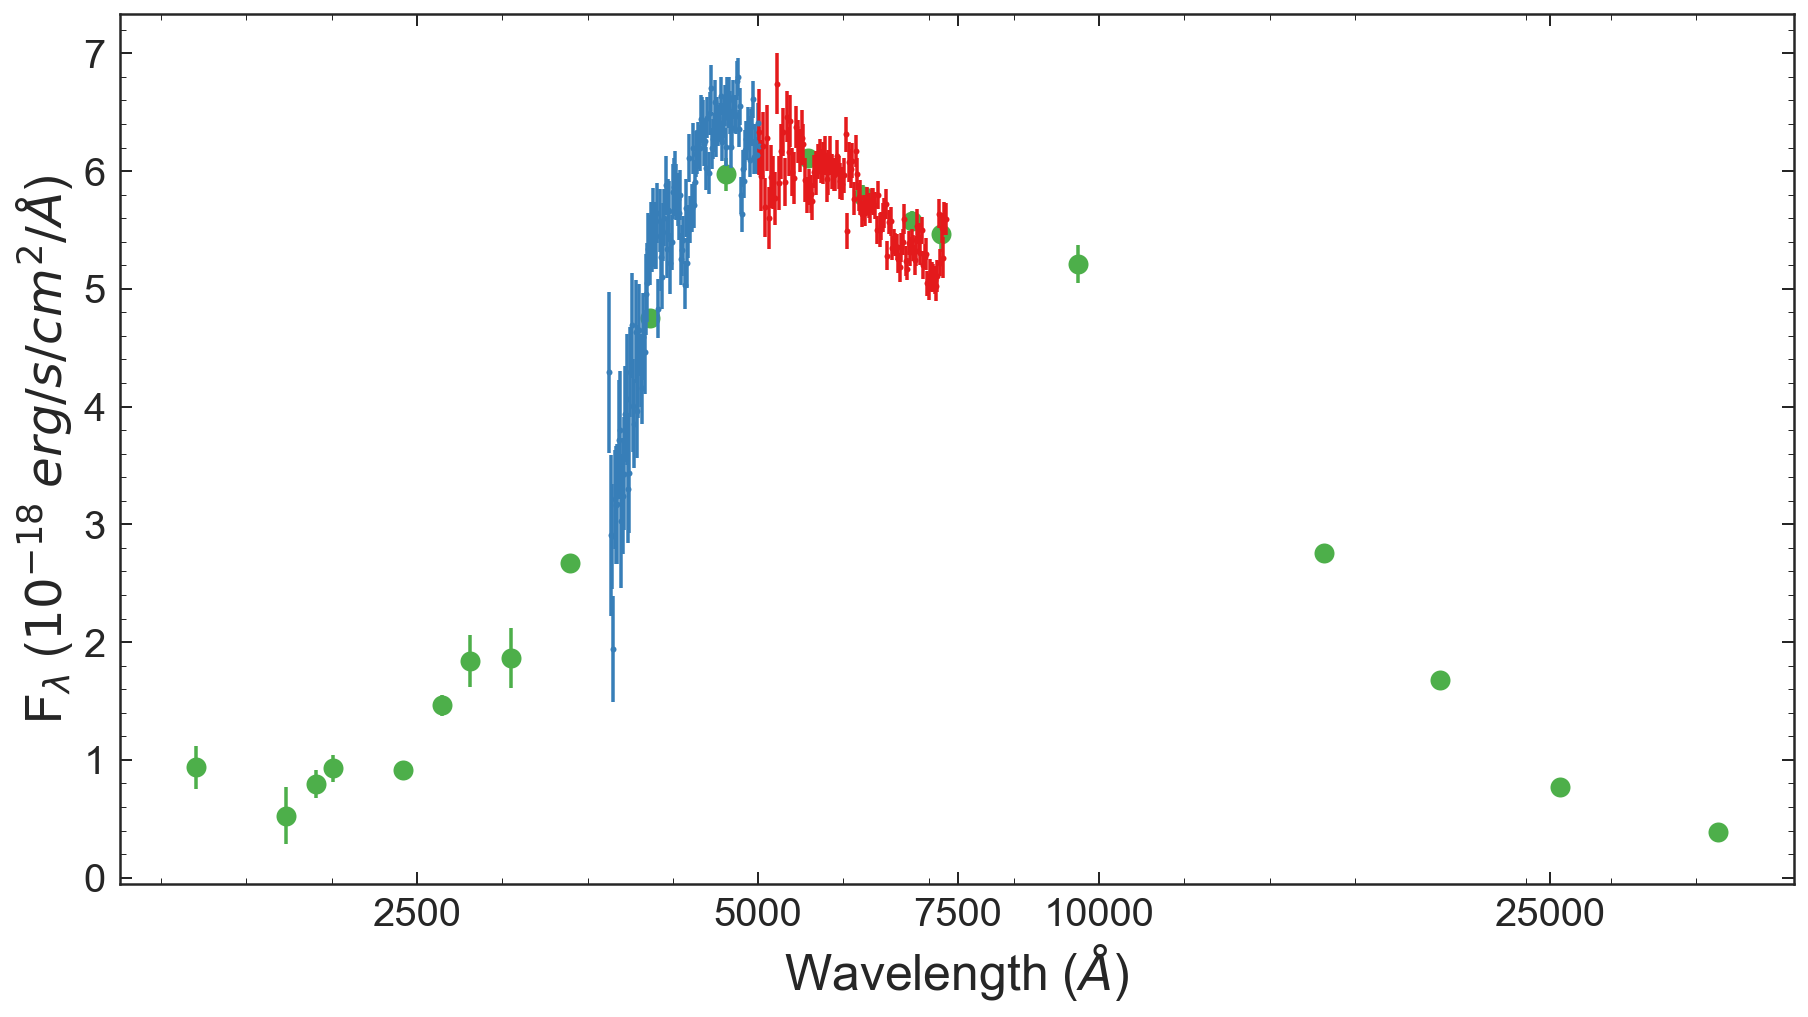

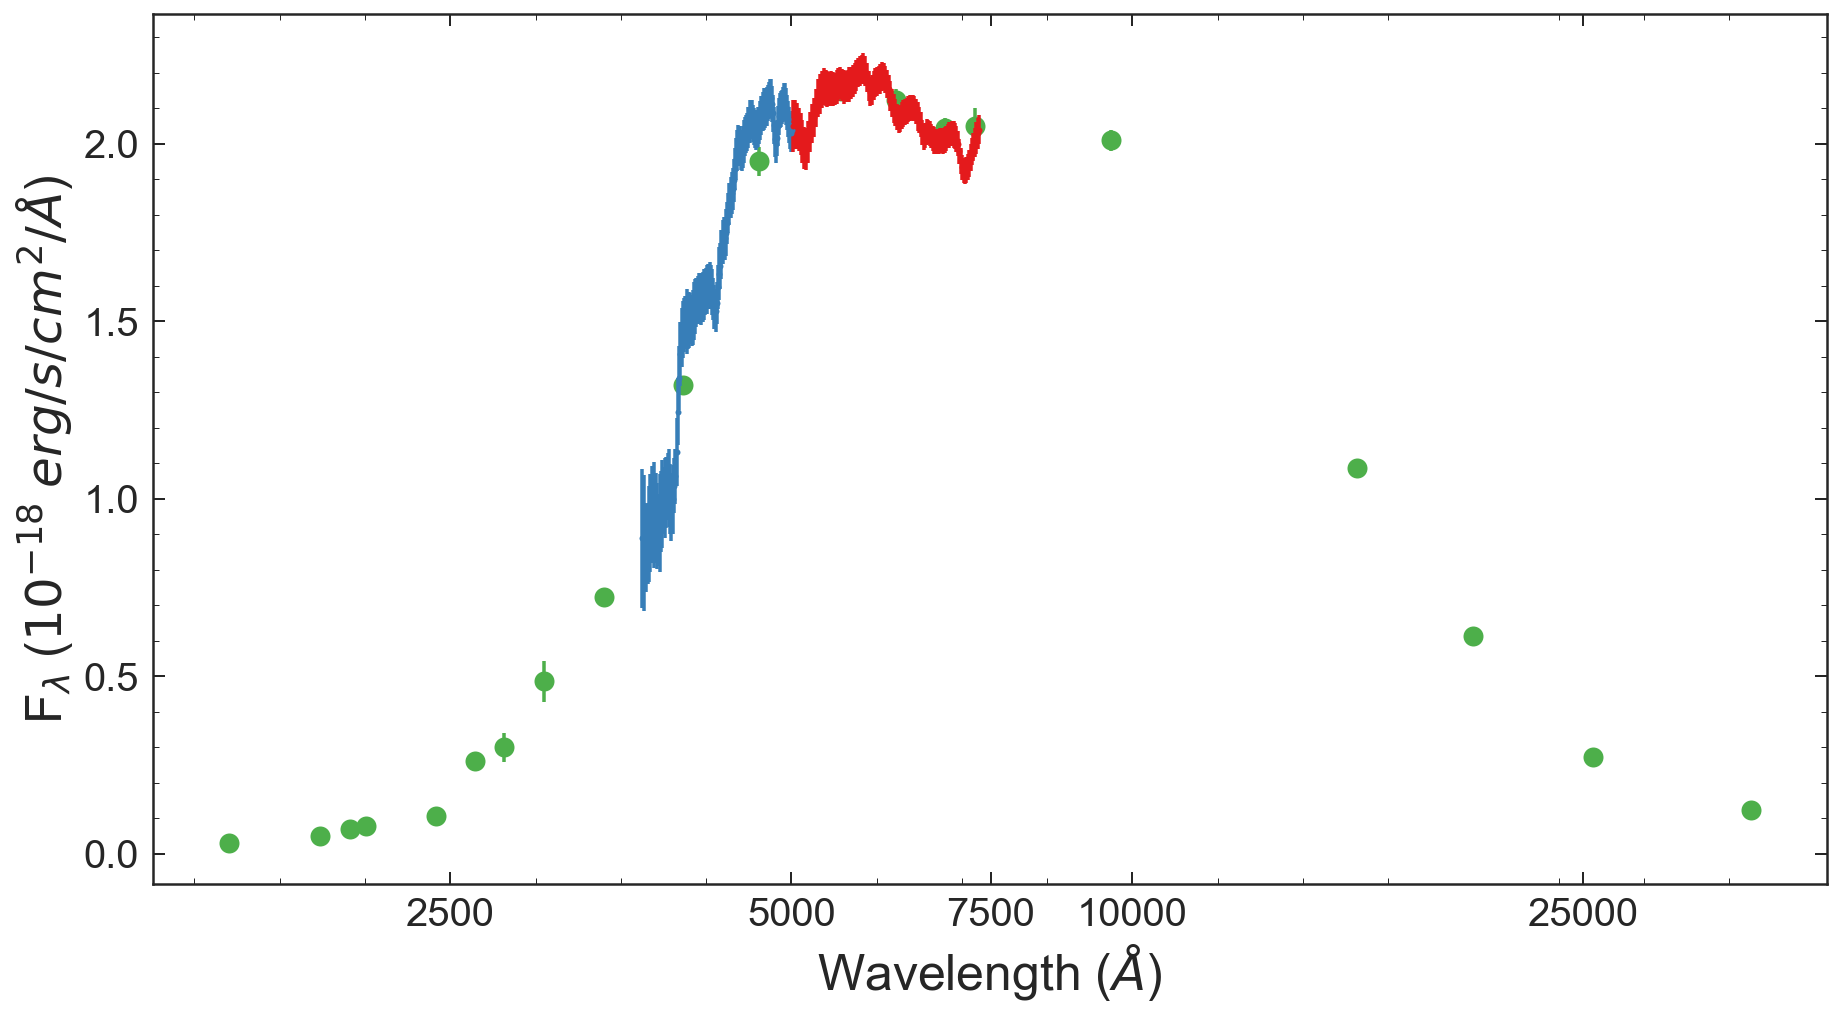

In [21]:
plt.figure(figsize = [15,8])
plt.errorbar(np.log10(sim1.Bwv_rf),sim1.SBfl*1E18,sim1.SBer*1E18,
                linestyle='None', marker='o', markersize=3, color='#377eb8',zorder = 2, label = 'CLEAR G102')
plt.errorbar(np.log10(sim1.Rwv_rf),sim1.SRfl*1E18,sim1.SRer*1E18,
                linestyle='None', marker='o', markersize=3, color='#e41a1c',zorder = 2, label = '3D-HST G141')
plt.errorbar(np.log10(sim1.Pwv_rf),sim1.SPflx*1E18,sim1.SPerr*1E18,
                                 linestyle='None', marker='o', markersize=10, color='#4daf4a',zorder = 1, label = '3D-HST Photometry')

plt.xticks(np.log10([2500,5000,7500,10000,25000]),[2500,5000,7500,10000,25000])

plt.xlabel('Wavelength ($\AA$)', fontsize=25)
plt.ylabel('F$_\lambda$ ($10^{-18}$ $erg/s/cm^{2}/\AA $)', fontsize=25)
plt.tick_params(axis='both', which='major', labelsize=20)

plt.figure(figsize = [15,8])
plt.errorbar(np.log10(sim2.Bwv_rf),sim2.SBfl*1E18,sim2.SBer*1E18,
                linestyle='None', marker='o', markersize=3, color='#377eb8',zorder = 2, label = 'CLEAR G102')
plt.errorbar(np.log10(sim2.Rwv_rf),sim2.SRfl*1E18,sim2.SRer*1E18,
                linestyle='None', marker='o', markersize=3, color='#e41a1c',zorder = 2, label = '3D-HST G141')
plt.errorbar(np.log10(sim2.Pwv_rf),sim2.SPflx*1E18,sim2.SPerr*1E18,
                                 linestyle='None', marker='o', markersize=10, color='#4daf4a',zorder = 1, label = '3D-HST Photometry')

plt.xticks(np.log10([2500,5000,7500,10000,25000]),[2500,5000,7500,10000,25000])

plt.xlabel('Wavelength ($\AA$)', fontsize=25)
plt.ylabel('F$_\lambda$ ($10^{-18}$ $erg/s/cm^{2}/\AA $)', fontsize=25)
plt.tick_params(axis='both', which='major', labelsize=20)

# review results for tab fit delay

In [4]:
dres = np.load('../data/out_dict/sim_test_tab_to_delay_1.npy').item()

In [18]:
t,pt = Get_posterior(dres.samples[:,2], dres.logwt,dres.logz)

t[pt == max(pt)][0]

0.23838058397068443

In [43]:
def Get_posterior(sample,logwt,logz):
    weight = np.exp(logwt - logz[-1])

    q = [0.5 - 0.5 * 0.999999426697, 0.5 + 0.5 * 0.999999426697]
    span = _quantile(sample.T, q, weights=weight)

    s = 0.02

    bins = int(round(10. / 0.02))
    n, b = np.histogram(sample, bins=bins, weights=weight,
                        range=np.sort(span))
    n = norm_kde(n, 10.)
    x0 = 0.5 * (b[1:] + b[:-1])
    y0 = n
    
    return x0, y0 / np.trapz(y0,x0)

0.23838058397068443
0.1977077191669148
0.22975660467525988
0.2003150755880947
0.2660964197920001


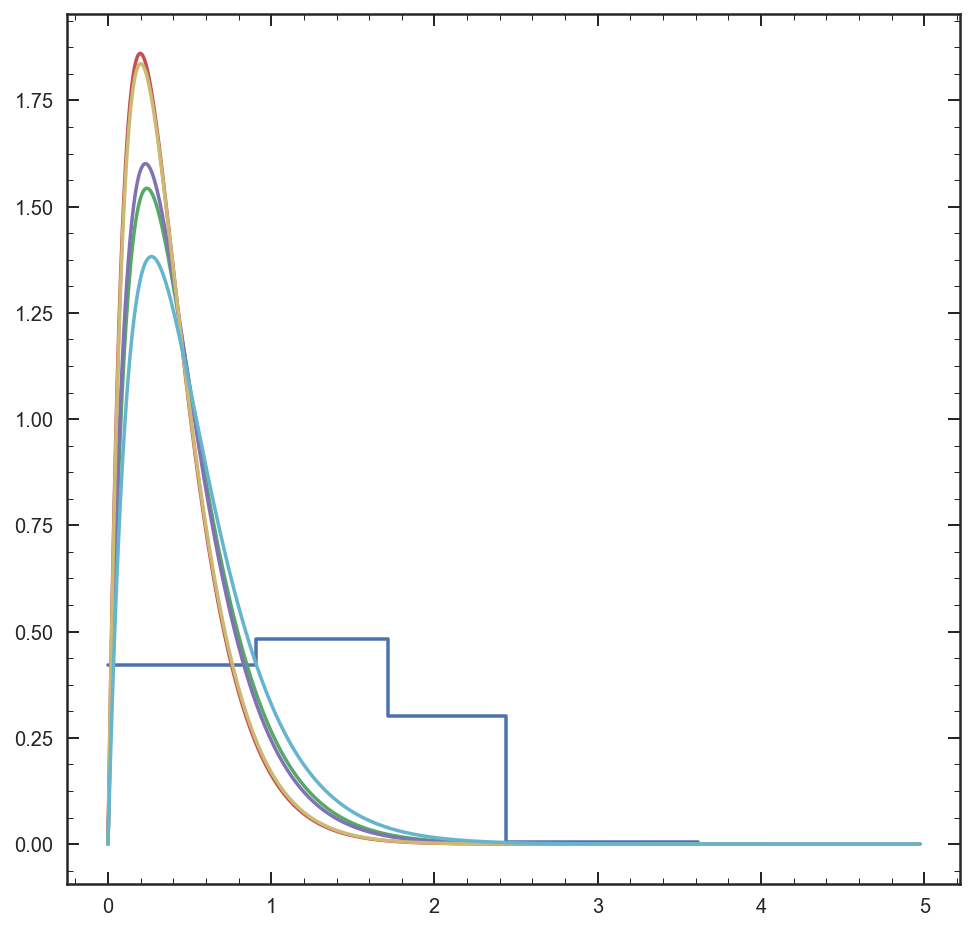

In [21]:
T= np.arange(0,Oldest_galaxy(1.25)+.001,.001)

plt.figure(figsize=[8,8])
plt.step(np.append(0,LBT), np.append(tabsfh[0], tabsfh))


for i in range(5):
    dres = np.load('../data/out_dict/sim_test_tab_to_delay_{0}.npy'.format(i+1)).item()
    
    t,pt = Get_posterior(dres.samples[:,2], dres.logwt,dres.logz)

    tau = t[pt == max(pt)][0]
    
    sfh = T * np.exp(-T / tau)

    sfh /= np.trapz(sfh,T)
    
    plt.plot(T,sfh)
    print(tau)

In [47]:
from prospect.models.transforms import logsfr_ratios_to_masses
lages = [0,9.0,9.1,9.2,9.3,9.4,9.5,9.6,9.7,9.8,9.9]

tuniv = Oldest_galaxy(specz)
nbins = len(lages) - 1

tbinmax = (tuniv * 0.85) * 1e9
lim1, lim2 = 7.4772, 8.0
agelims = [0,lim1] + np.linspace(lim2,np.log10(tbinmax),nbins-2).tolist() + [np.log10(tuniv*1e9)]
agebins = np.array([agelims[:-1], agelims[1:]]).T

LBT2 = (10**agebins.T[1][::-1][0] - 10**agebins.T[0][::-1])*1E-9

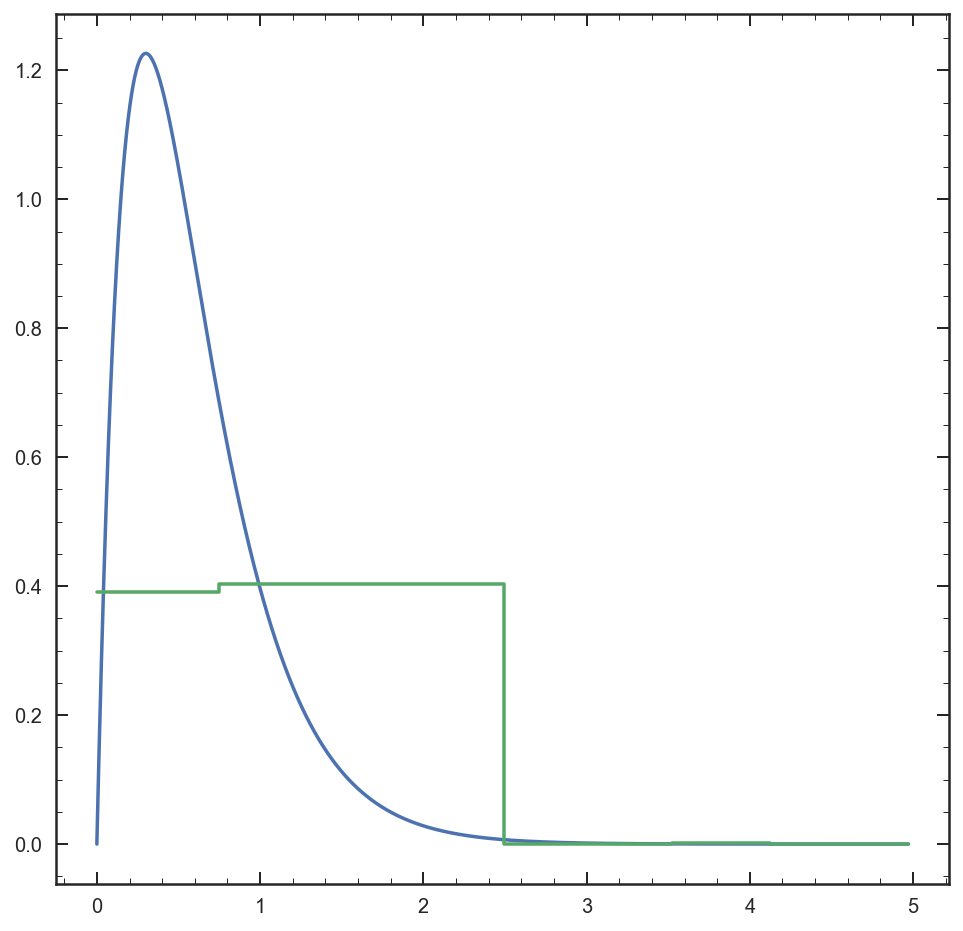

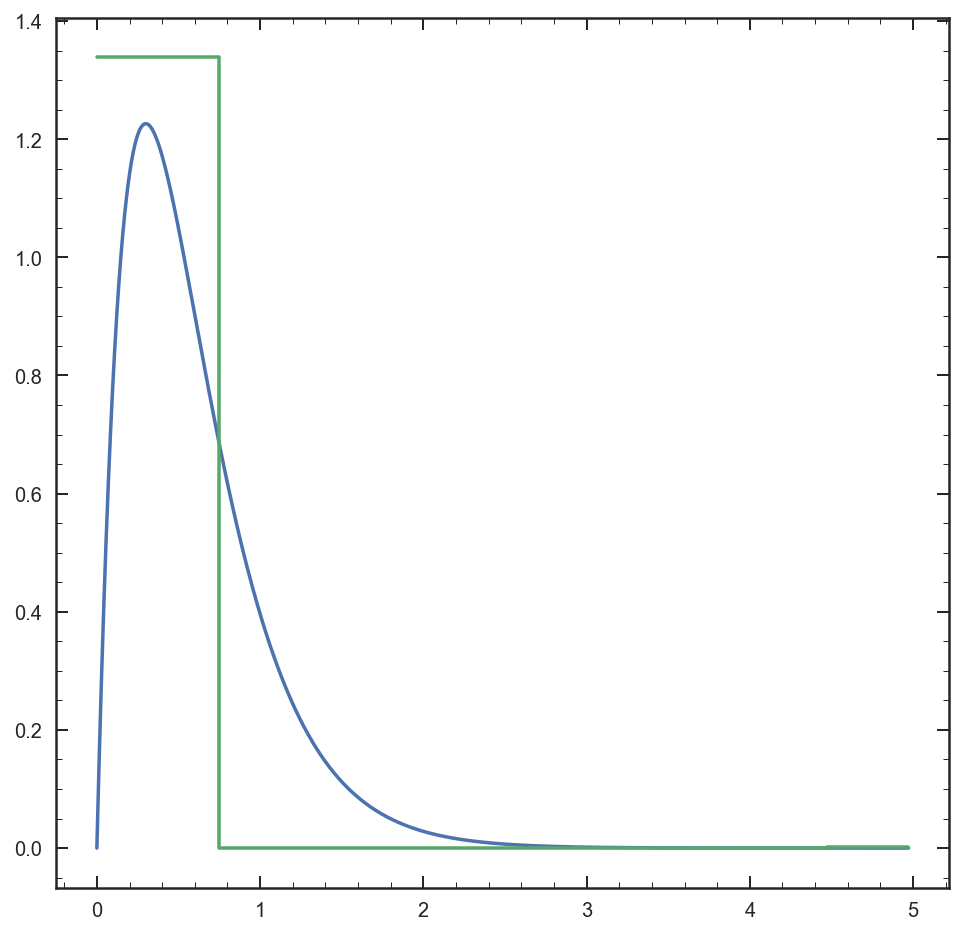

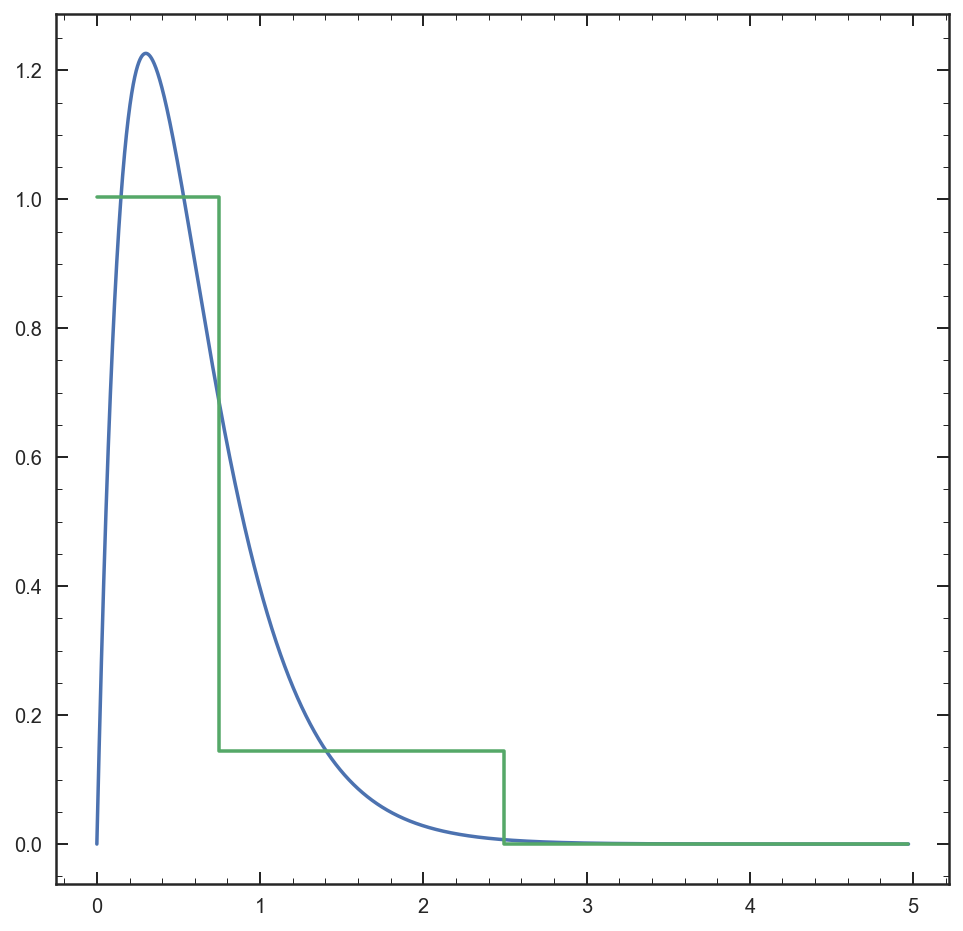

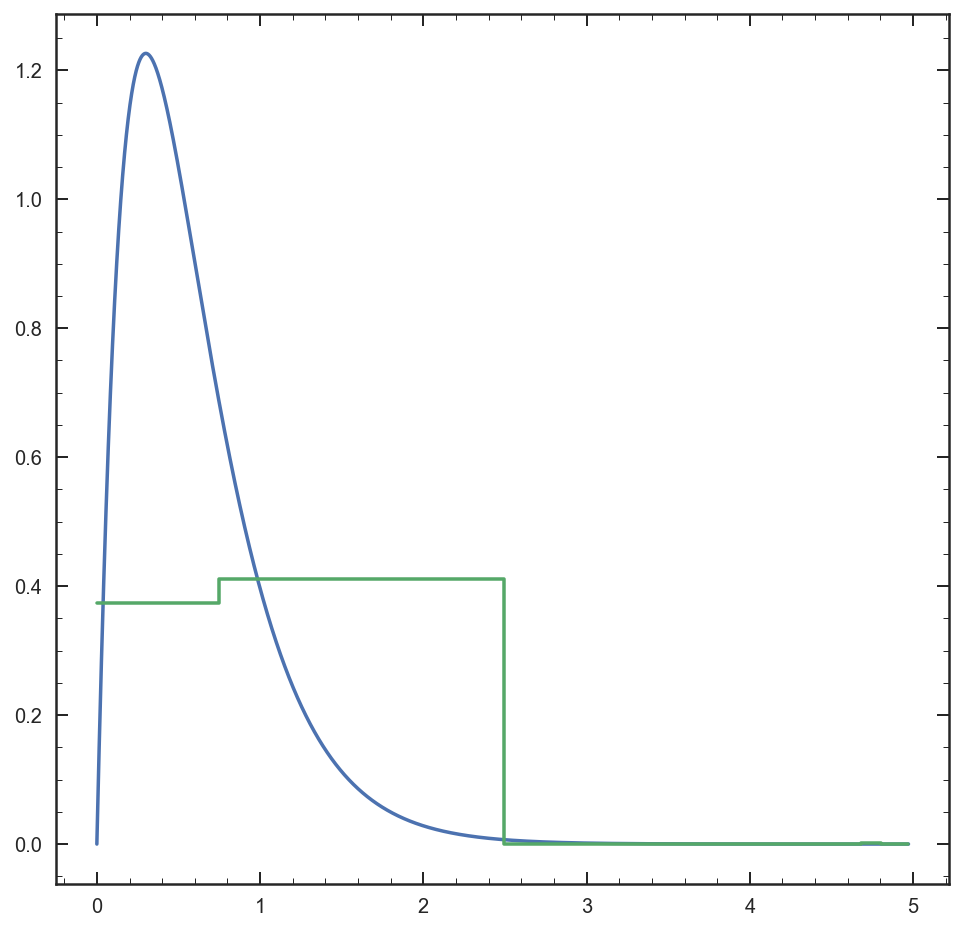

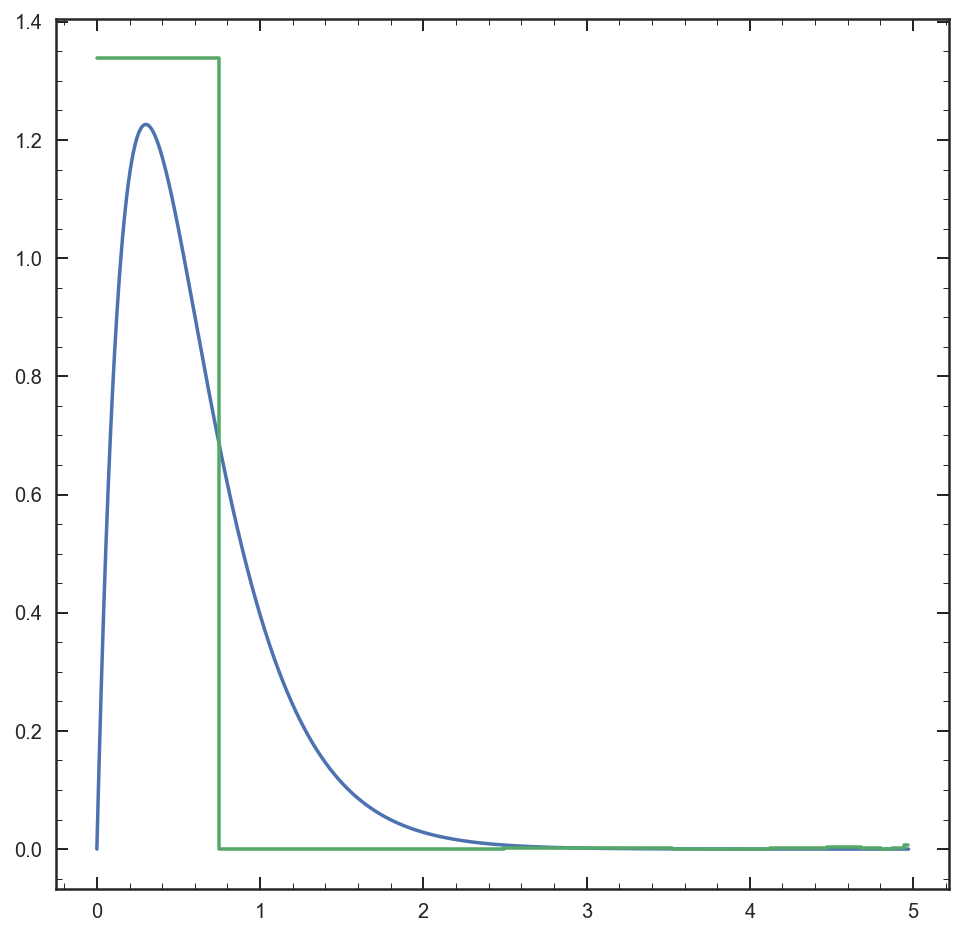

In [48]:
T= np.arange(0,Oldest_galaxy(1.25)+.001,.001)

sfh = T * np.exp(-T / 0.3)

sfh /= np.trapz(sfh,T)


# plt.figure(figsize=[8,8])
# plt.plot(T,sfh)

for i in range(5):
    dres = np.load('../data/out_dict/sim_test_delay_to_tab_continuity_prior_{0}.npy'.format(i+1)).item()
    
    md = np.zeros(10)

    for ii in range(10):
        t,pt = Get_posterior(dres.samples[:,ii + 2],dres.logwt,dres.logz)
        md[ii], le, he = Highest_density_region(pt,t)
    plt.figure(figsize=[8,8])
    plt.plot(T,sfh)
    plt.step(np.append(0,LBT2), np.append(md[0],md))

#     -3.997019316560724
# -1.4108905650027777
# -0.3605714330773583
# -0.5138456318282864
# -3.072313496025277

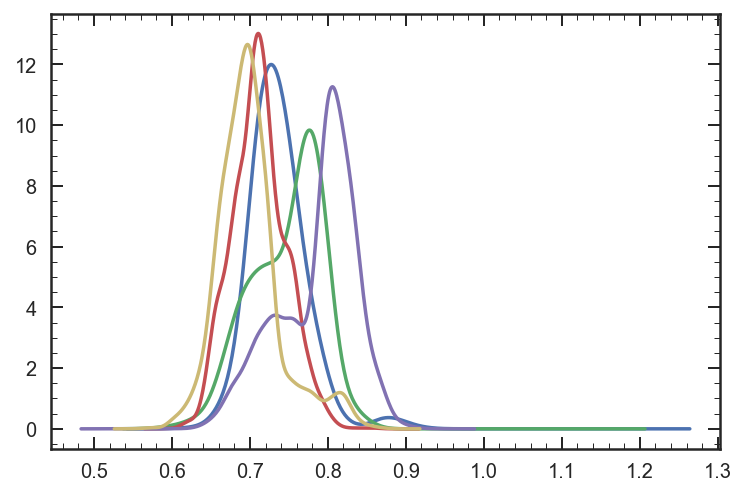

In [22]:
for i in range(5):
    dres = np.load('../data/out_dict/sim_test_tab_to_delay_{0}.npy'.format(i+1)).item()
    
    t,pt = Get_posterior(dres.samples[:,0], dres.logwt,dres.logz)
    
    plt.plot(t,pt)

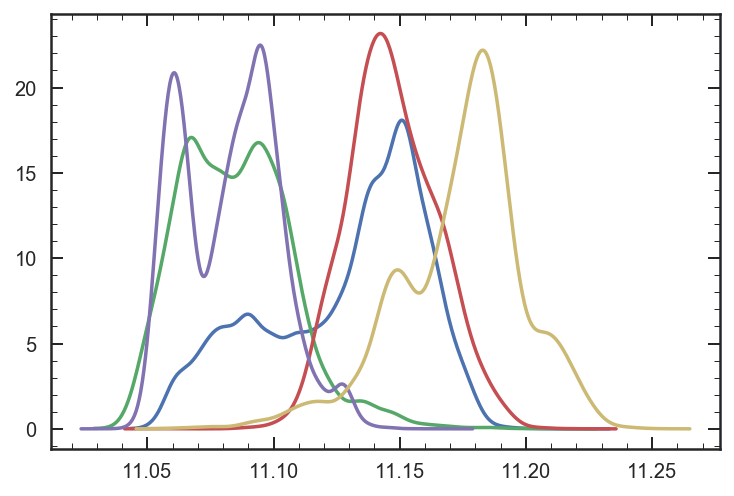

In [27]:
for i in range(5):
    dres = np.load('../data/out_dict/sim_test_tab_to_delay_{0}.npy'.format(i+1)).item()
    
    t,pt = Get_posterior(dres.samples[:,5], dres.logwt,dres.logz)
    
    plt.plot(t,pt)

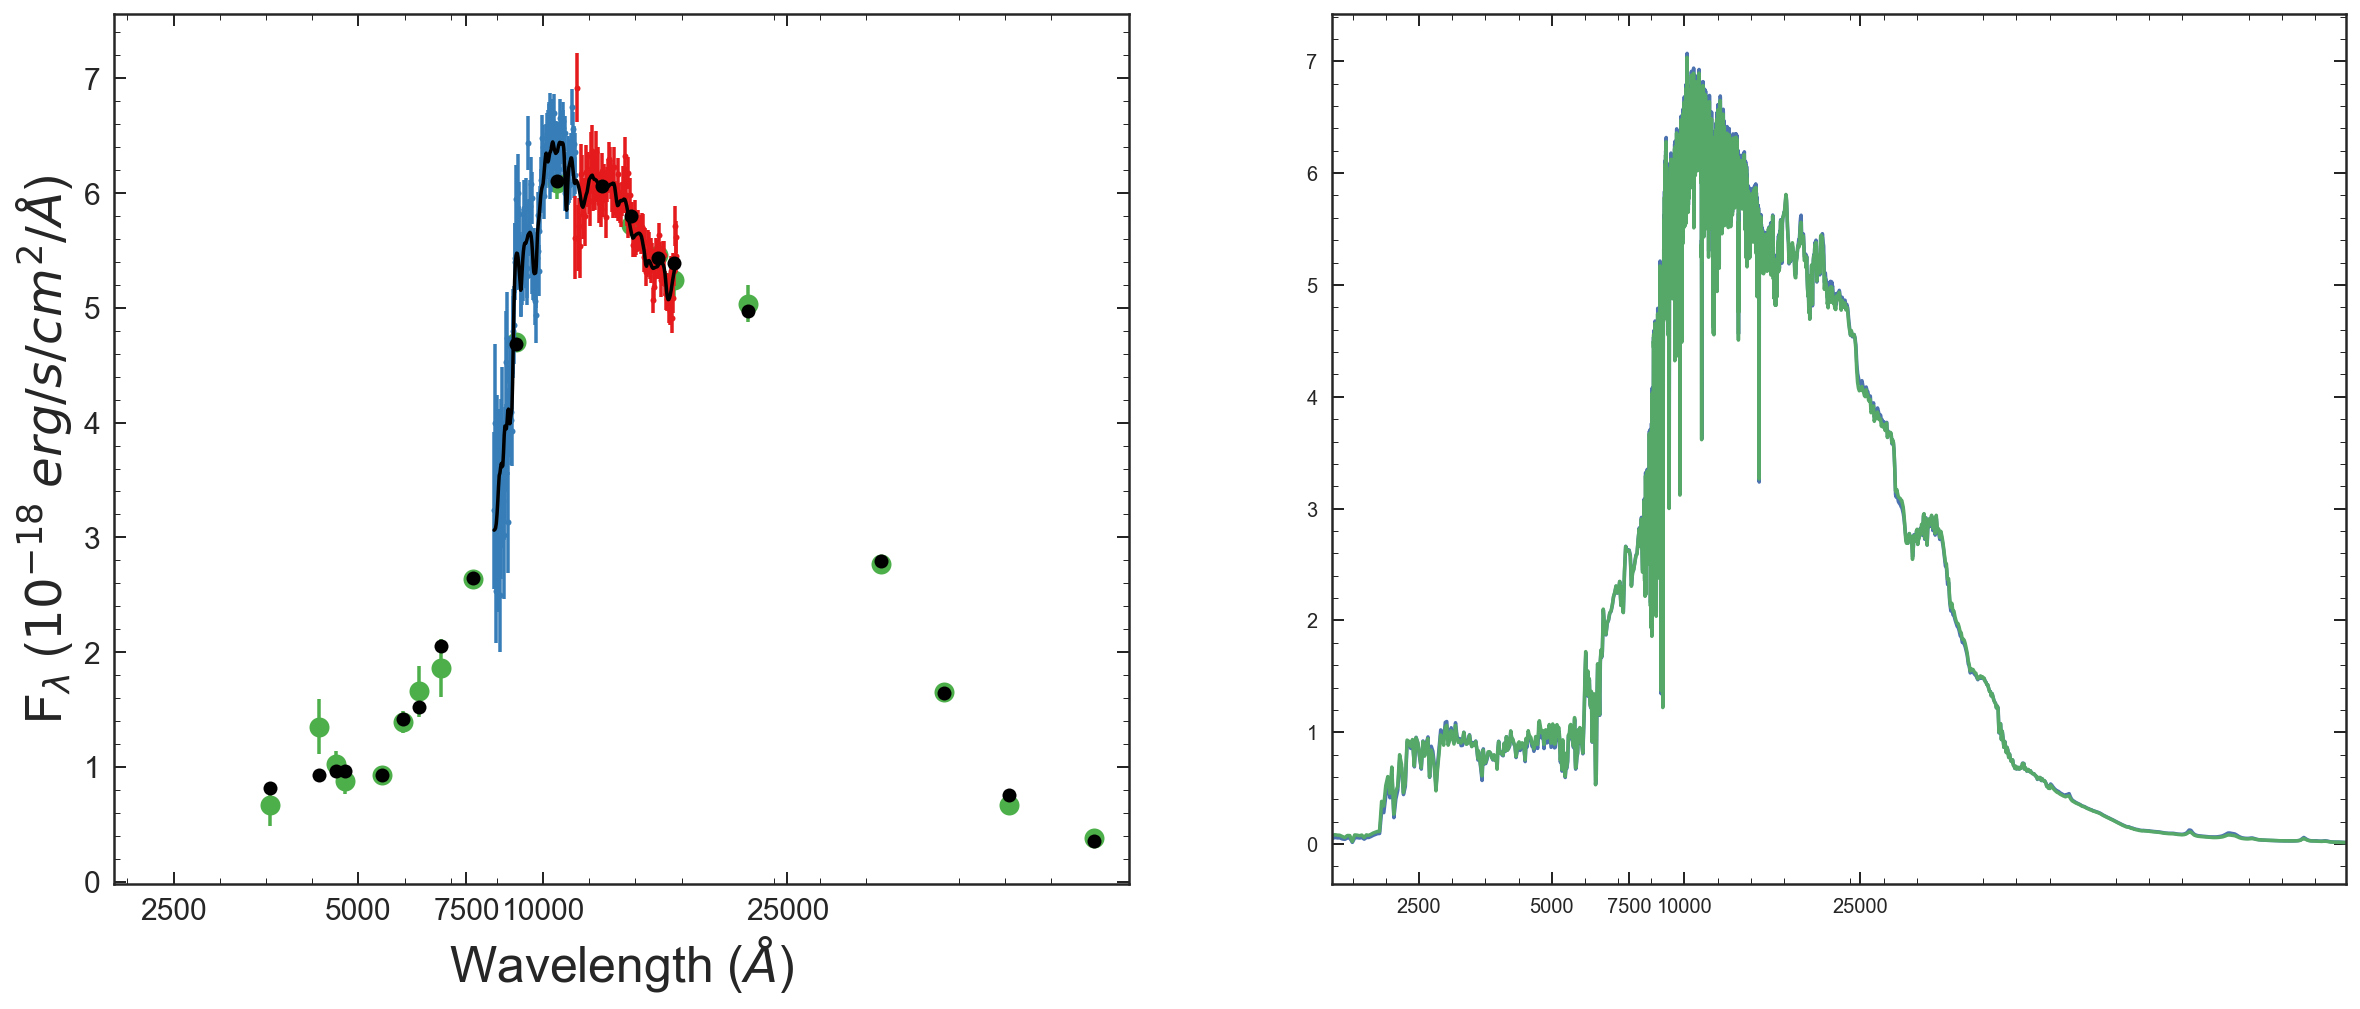

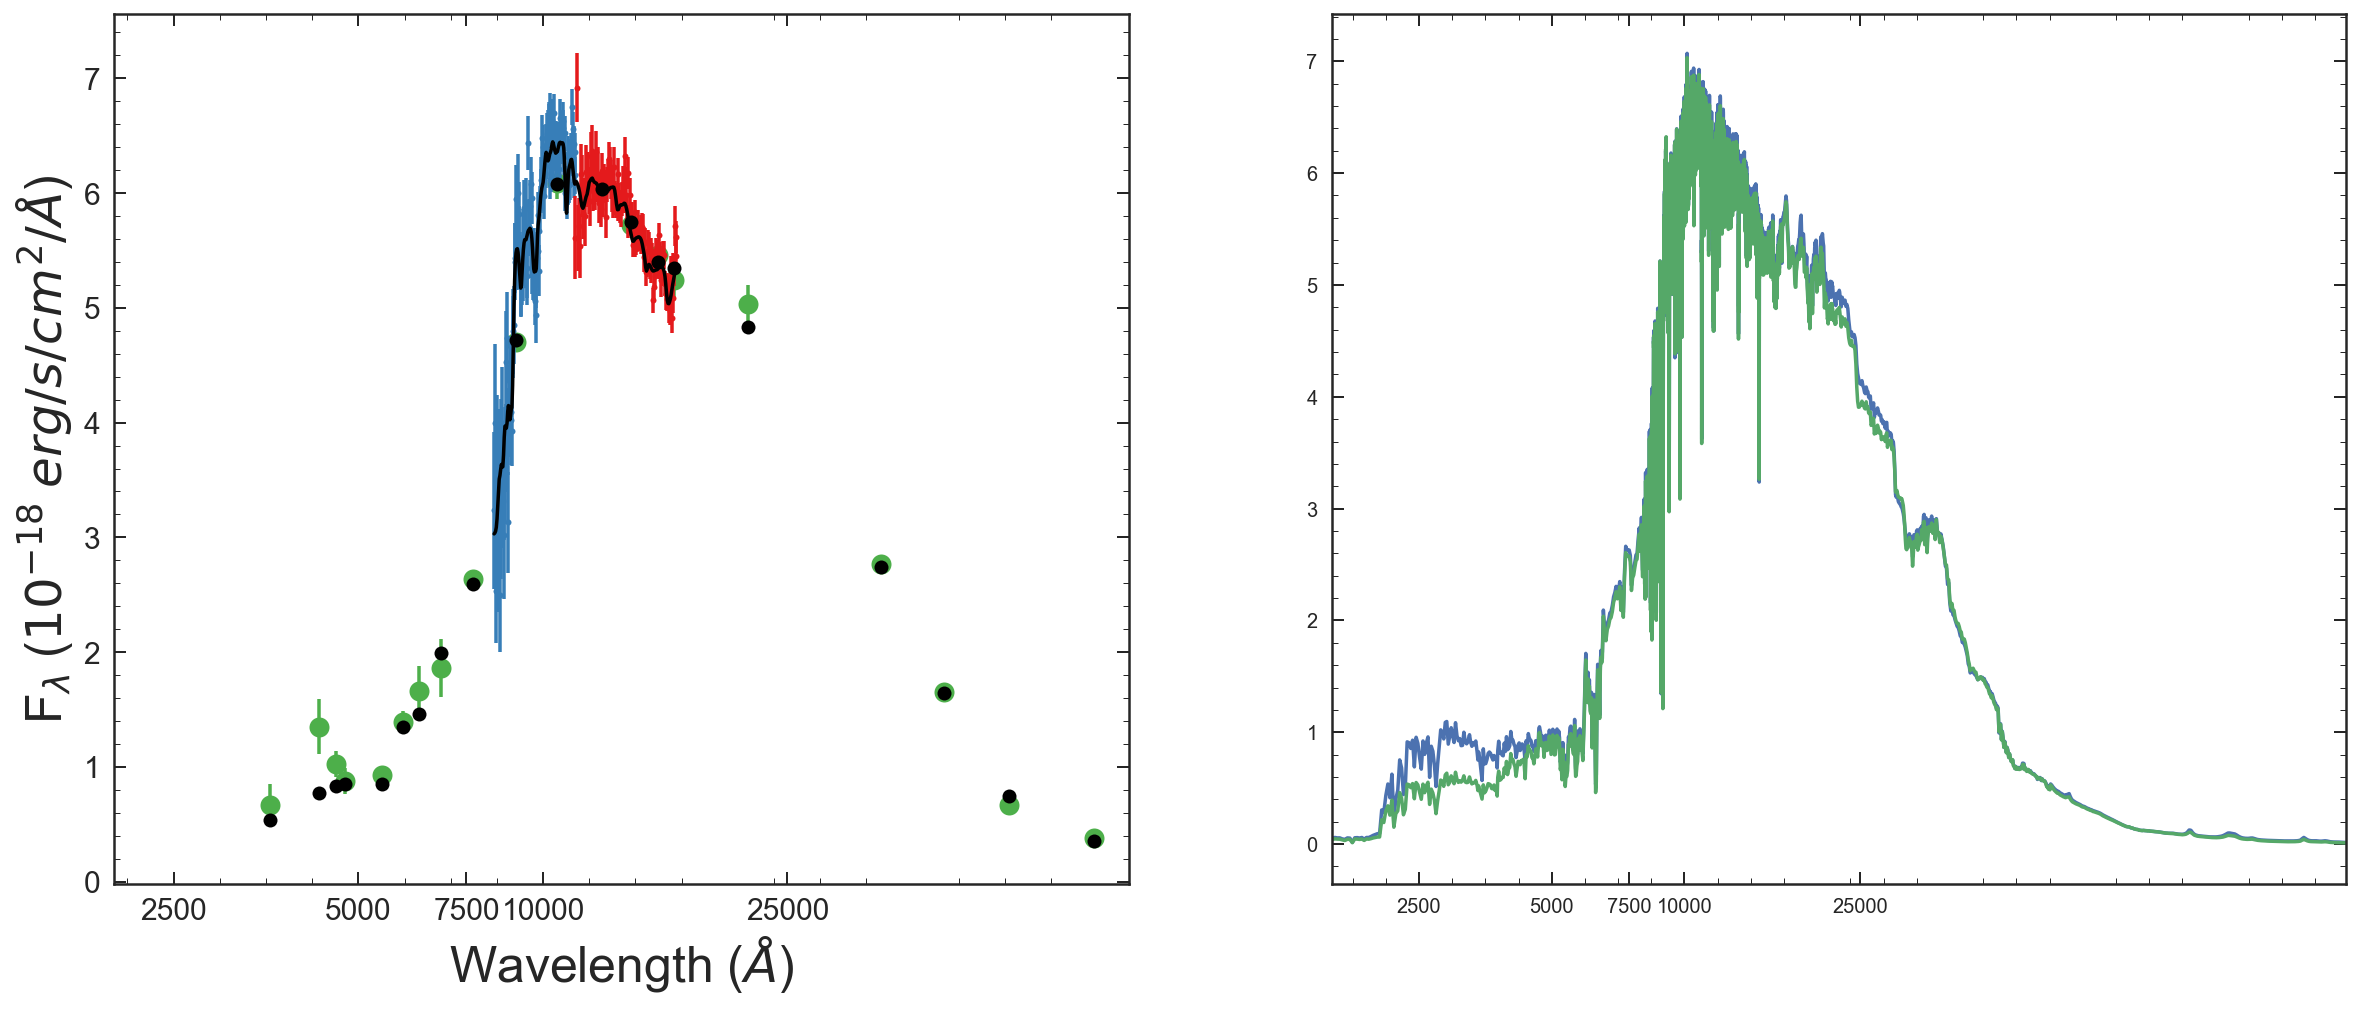

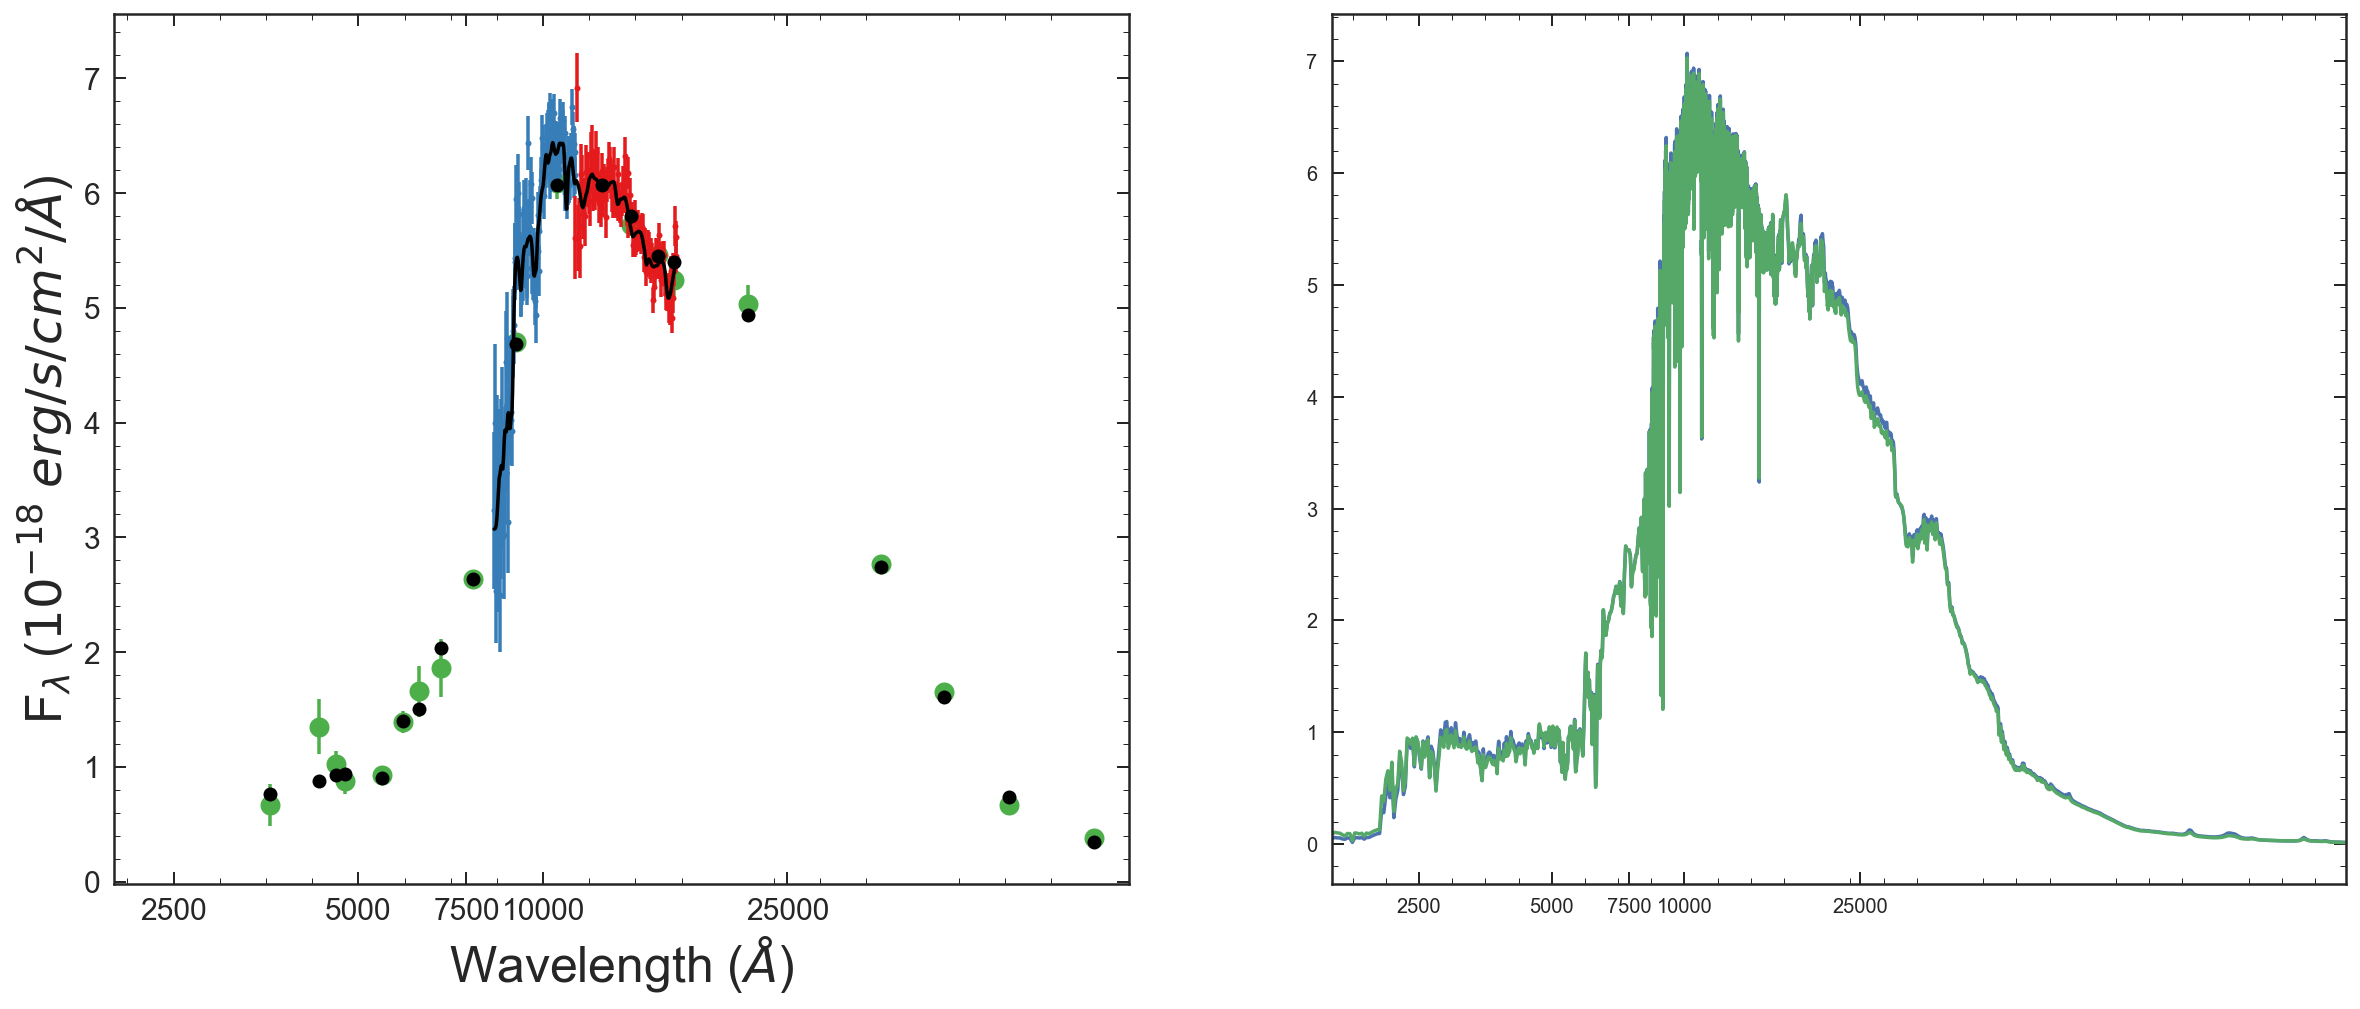

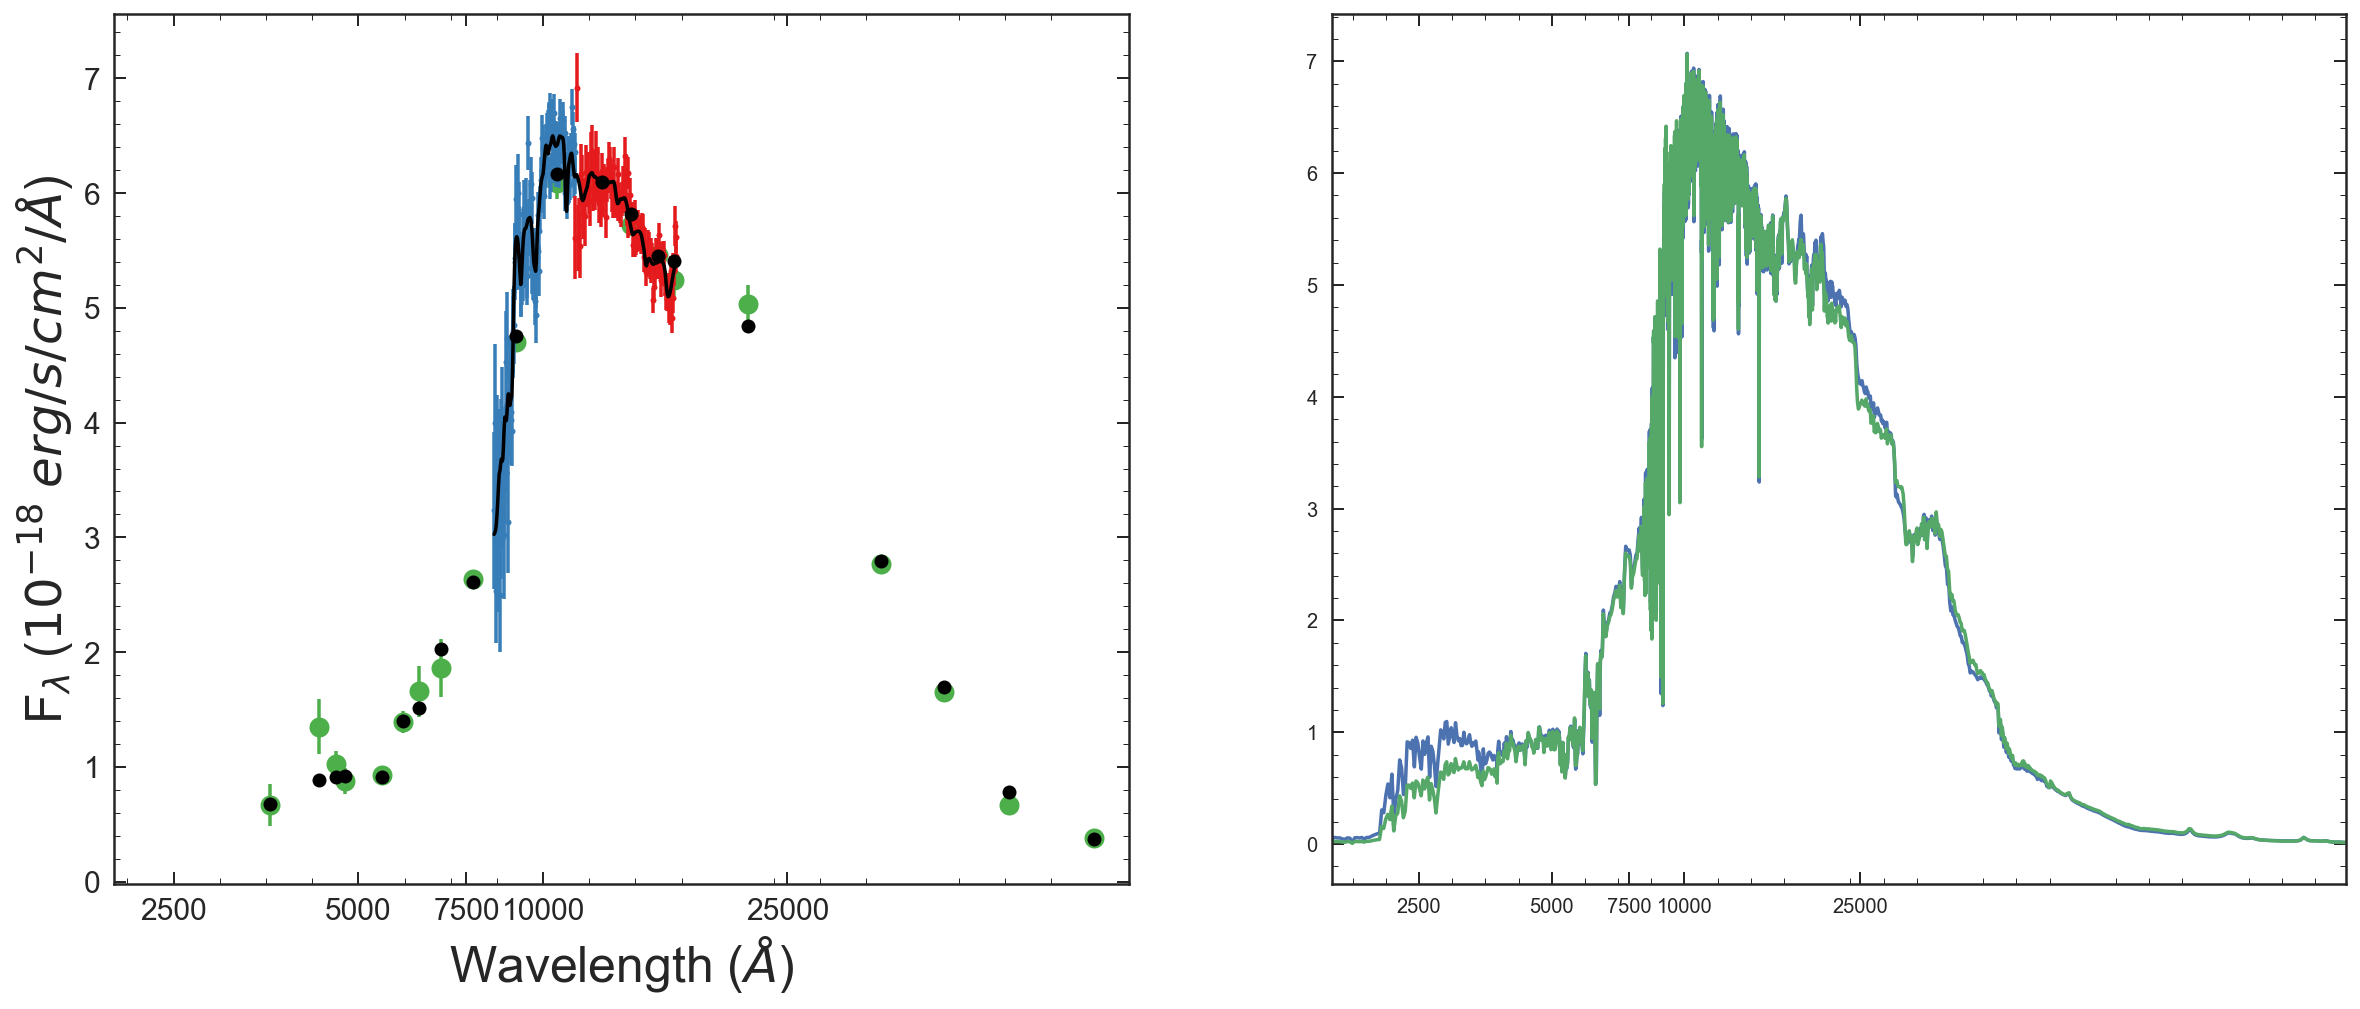

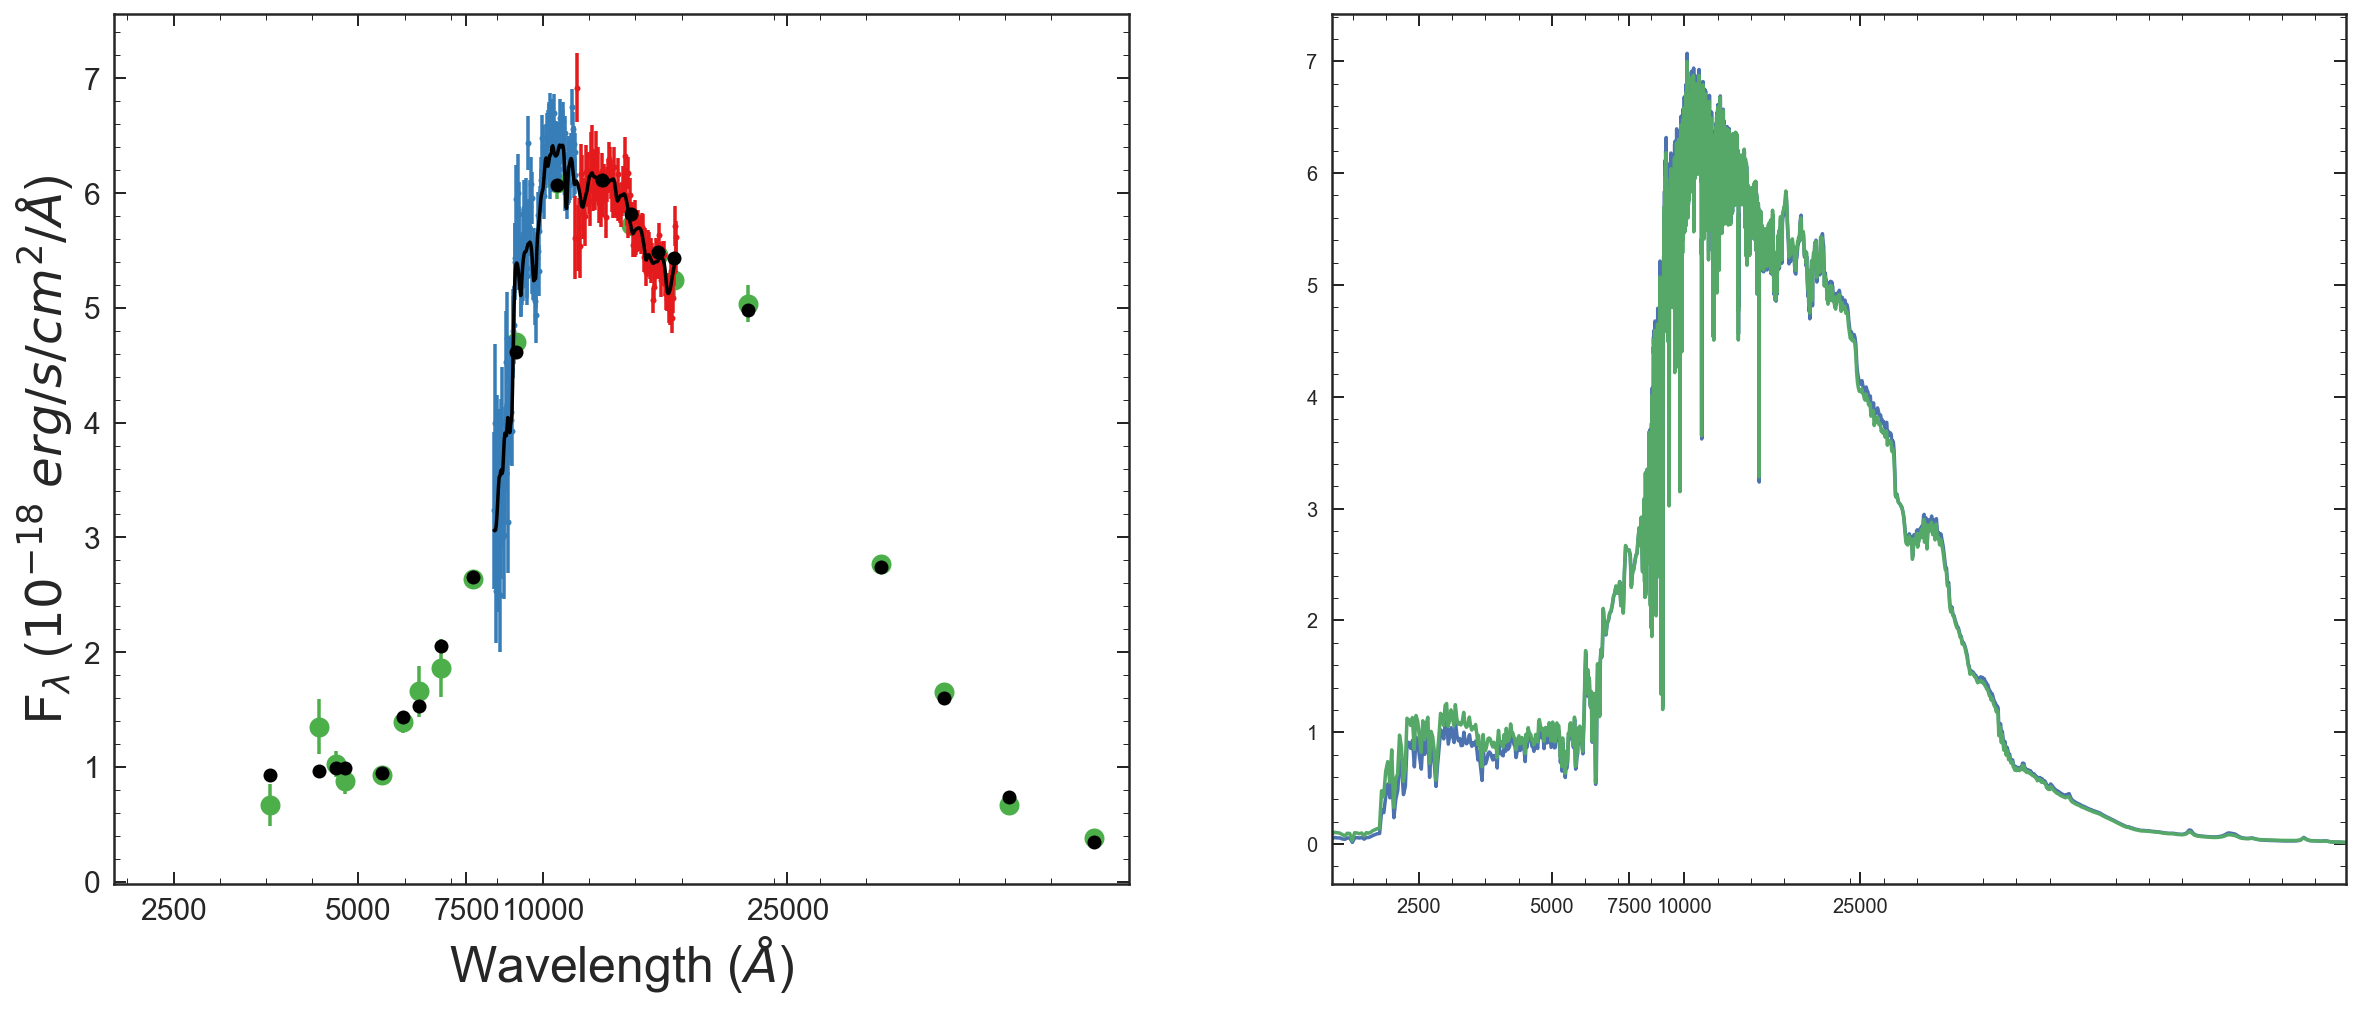

In [32]:
gs = GridSpec(1,2)

for i in range(5):
    dres = np.load('../data/out_dict/sim_test_tab_to_delay_{0}.npy'.format(i+1)).item()
    bfZ, bft, bftau, bfz, bfd, bfm = dres.samples[-1]

    sp.params['dust2'] =bfd
    sp.params['dust1'] =bfd
    sp.params['tau'] =bftau
    sp.params['logzsol'] = np.log10(bfZ)

    wavetd, fluxtd = sp.get_spectrum(tage = bft, peraa = True)
    D_l = cosmo.luminosity_distance(bfz).value # in Mpc

    sim1.Sim_all_premade(wavetd* (1+bfz), fluxtd * 10**bfm* lsol_to_fsol / (4 * np.pi * (D_l*conv)**2), scale=False)

    plt.figure(figsize = [20,8])
    plt.subplot(gs[0])
    
    
    plt.errorbar(np.log10(sim1.Bwv),sim1.SBfl*1E18,sim1.SBer*1E18,
                    linestyle='None', marker='o', markersize=3, color='#377eb8',zorder = 2, label = 'CLEAR G102')
    plt.errorbar(np.log10(sim1.Rwv),sim1.SRfl*1E18,sim1.SRer*1E18,
                    linestyle='None', marker='o', markersize=3, color='#e41a1c',zorder = 2, label = '3D-HST G141')
    plt.errorbar(np.log10(sim1.Pwv),sim1.SPflx*1E18,sim1.SPerr*1E18,
                                     linestyle='None', marker='o', markersize=10, color='#4daf4a',zorder = 1, label = '3D-HST Photometry')
    plt.plot(np.log10(sim1.Bwv), sim1.Bmfl*1E18, 'k', zorder=5)
    plt.plot(np.log10(sim1.Rwv), sim1.Rmfl*1E18, 'k', zorder=5)
    plt.plot(np.log10(sim1.Pwv), sim1.Pmfl*1E18, 'ko', zorder=5)
    # plt.xticks(np.log10([1000,2500,5000,7500,10000,25000]),[1000,2500,5000,7500,10000,25000])
    # plt.plot(np.log10(wave * (1)),flux  / (10**bfm*1E9 * conv))
    plt.xlim(np.log10(2000), np.log10(90000))




    plt.xticks(np.log10([2500,5000,7500,10000,25000]),[2500,5000,7500,10000,25000])

    plt.xlabel('Wavelength ($\AA$)', fontsize=25)
    plt.ylabel('F$_\lambda$ ($10^{-18}$ $erg/s/cm^{2}/\AA $)', fontsize=25)
    plt.tick_params(axis='both', which='major', labelsize=15)
    
    plt.subplot(gs[1])

    plt.plot(np.log10(wave1 * (1+specz)), flux1 * mass_transform*1E18)
    plt.plot(np.log10(wavetd* (1+bfz)), fluxtd * 10**bfm* lsol_to_fsol / (4 * np.pi * (D_l*conv)**2)*1E18)
    plt.xlim(3.2,5.5)
    plt.xticks(np.log10([2500,5000,7500,10000,25000]),[2500,5000,7500,10000,25000])


In [41]:
# get lightweighted age

sp = fsps.StellarPopulation(imf_type = 2, tpagb_norm_type=0, zcontinuous = 1, logzsol = np.log10(1), sfh = 4, tau=0.1, dust_type = 1, )
sp.params['compute_light_ages'] = True

PLWA = []
LWA = []


for i in range(5):
    dres = np.load('../data/out_dict/sim_test_tab_to_delay_{0}.npy'.format(i+1)).item()
    
    lwa = []
    
    for ii in range(len(dres.samples)):
        bfZ, bft, bftau, bfz, bfd, bfm = dres.samples[ii]

        sp.params['dust2'] =bfd
        sp.params['dust1'] =bfd
        sp.params['tau'] =bftau
        sp.params['logzsol'] = np.log10(bfZ)

        lwa.append(sp.get_mags(tage = bft, bands =['sdss_g'])[0])
    
    t,pt = Get_posterior(np.array(lwa), dres.logwt,dres.logz)
    LWA.append(t)
    PLWA.append(pt)
    
        
sp.params['compute_light_ages'] = False
        

In [44]:
sp = fsps.StellarPopulation(imf_type = 2, tpagb_norm_type=0, zcontinuous = 3, sfh = 3, dust_type = 1)
sp.params['compute_light_ages'] = True

sp.params['dust2'] =0.2
sp.params['dust1'] =0.2

tab_sfh = np.array([0.7, 0.8, 0.5, 0.01, 0.01, 0.001, 0.00001, 0.0002, 0.002, 0.0001])
tab_Z = np.array([0.2, 0.8, 1.0, 1.0, 0.8, 1.1, 0.7, 0.8, 0.8, 0.8])*0.019

sp.set_tabular_sfh(LBT,tab_sfh,
                   Z = tab_Z )

lwa1 = sp.get_mags(tage = 3.5, bands =['sdss_g'])
       
sp.params['compute_light_ages'] = False

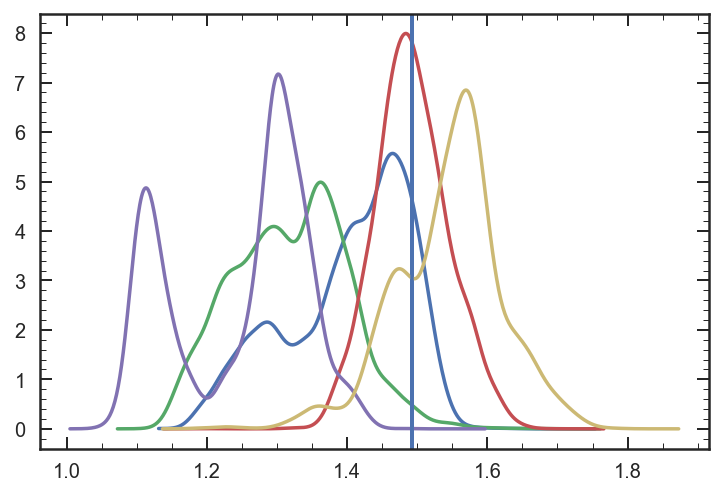

In [45]:
for i in range(5):
    plt.plot(LWA[i], PLWA[i])
    plt.axvline(lwa1)

-195060.09787883097
-227102.4729581006
-359.0843541439398
-145888.09850561916
-155218.56074494708


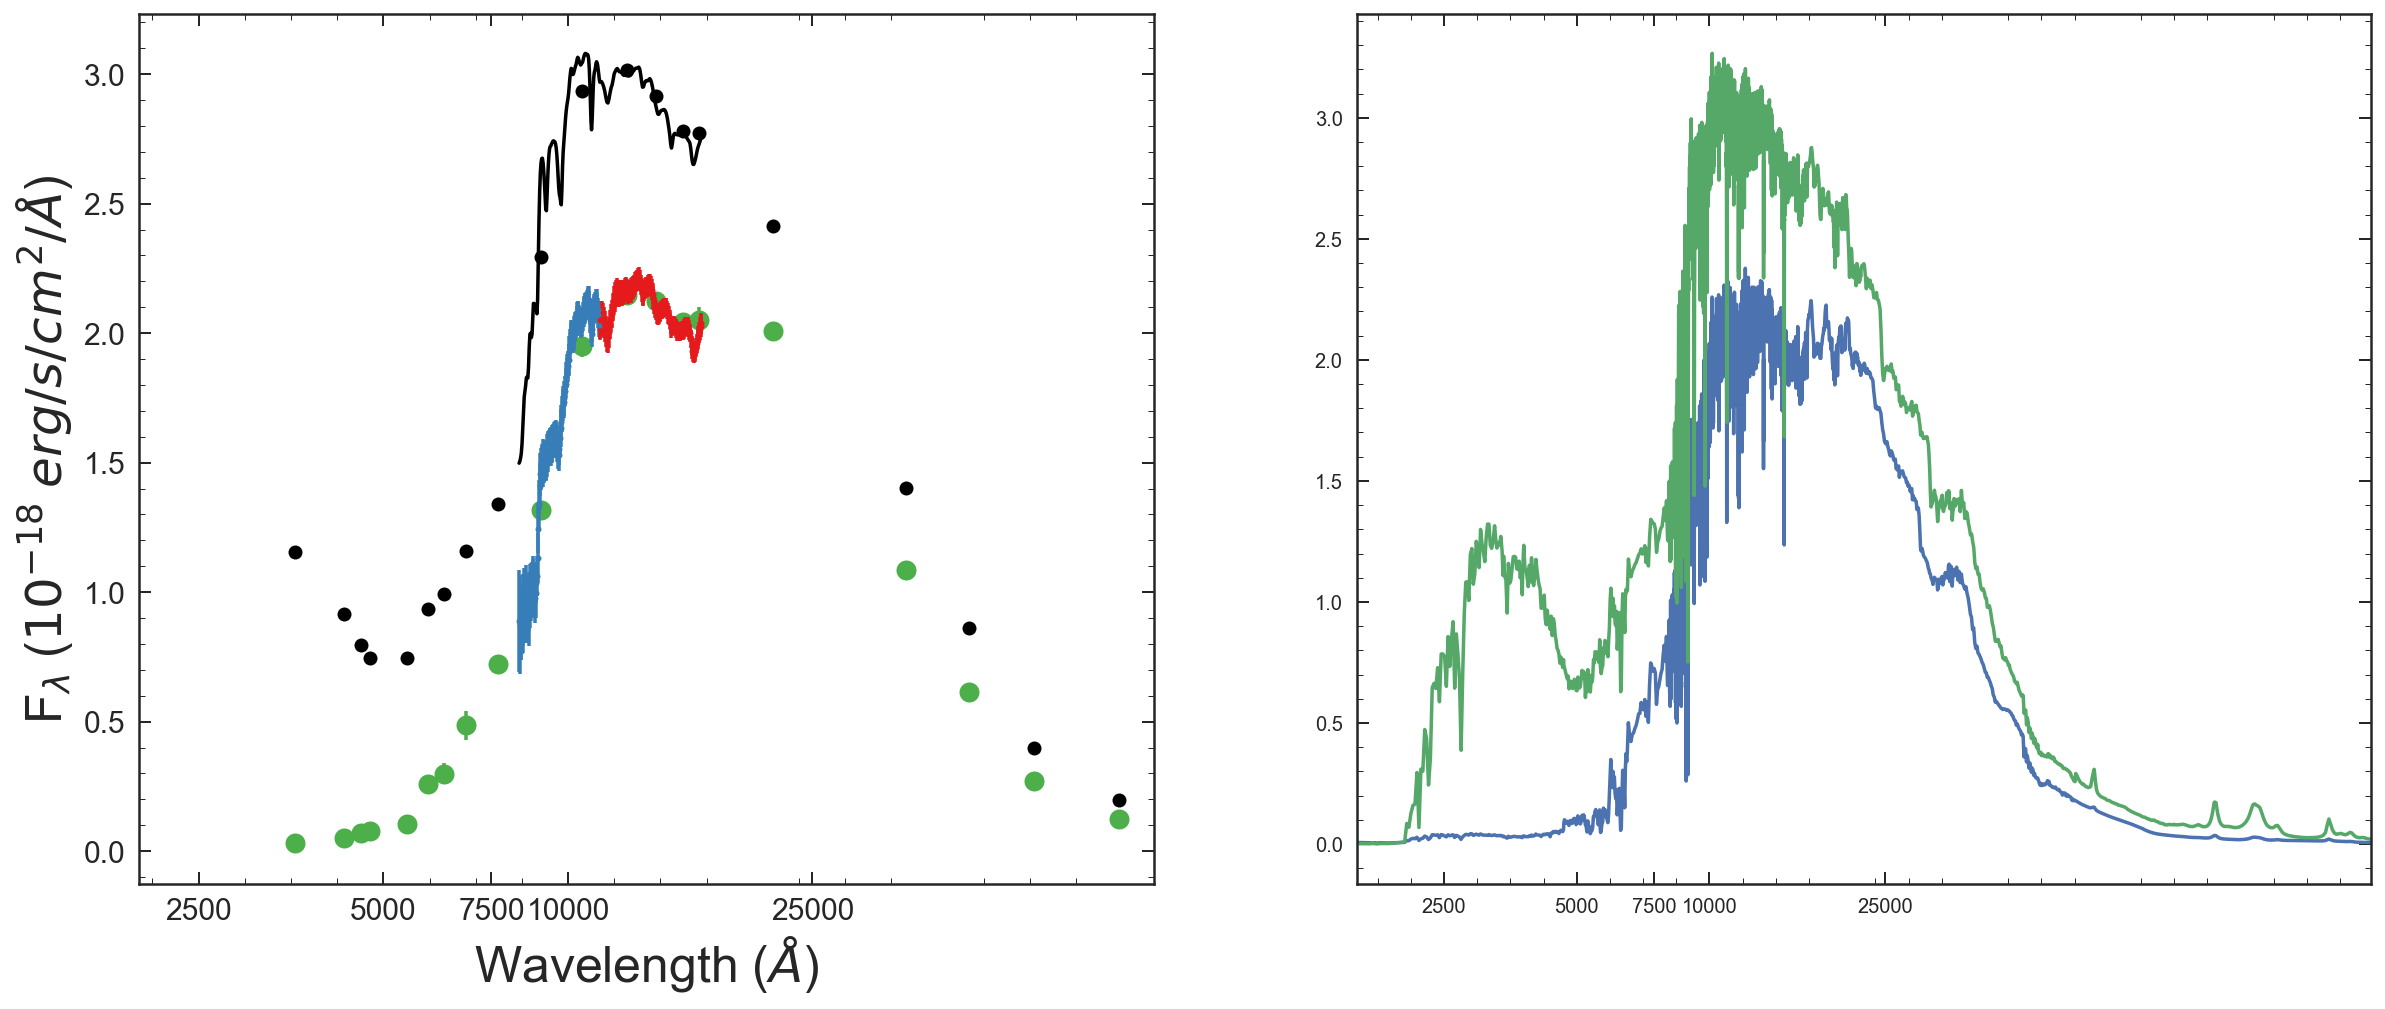

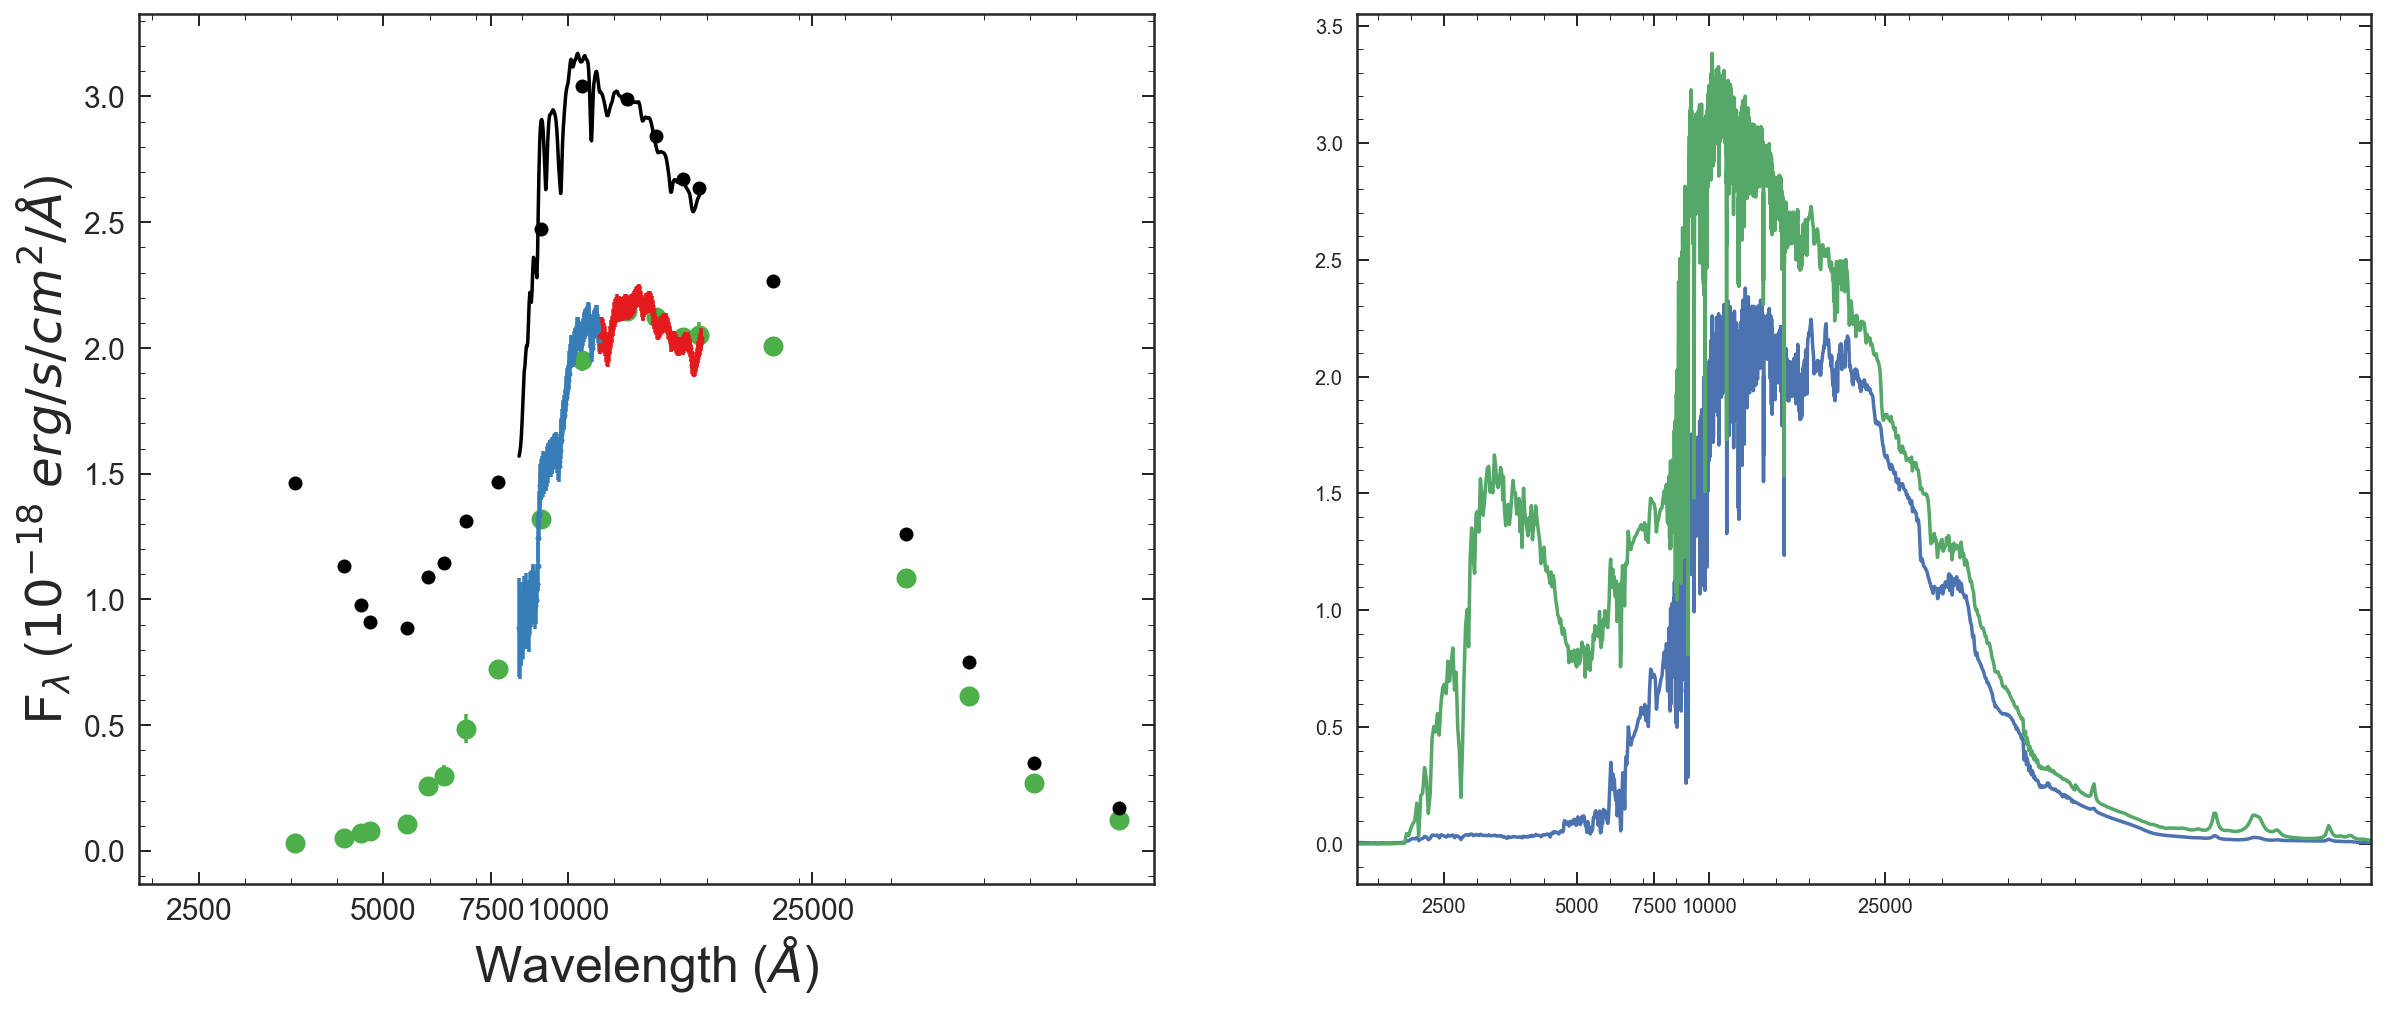

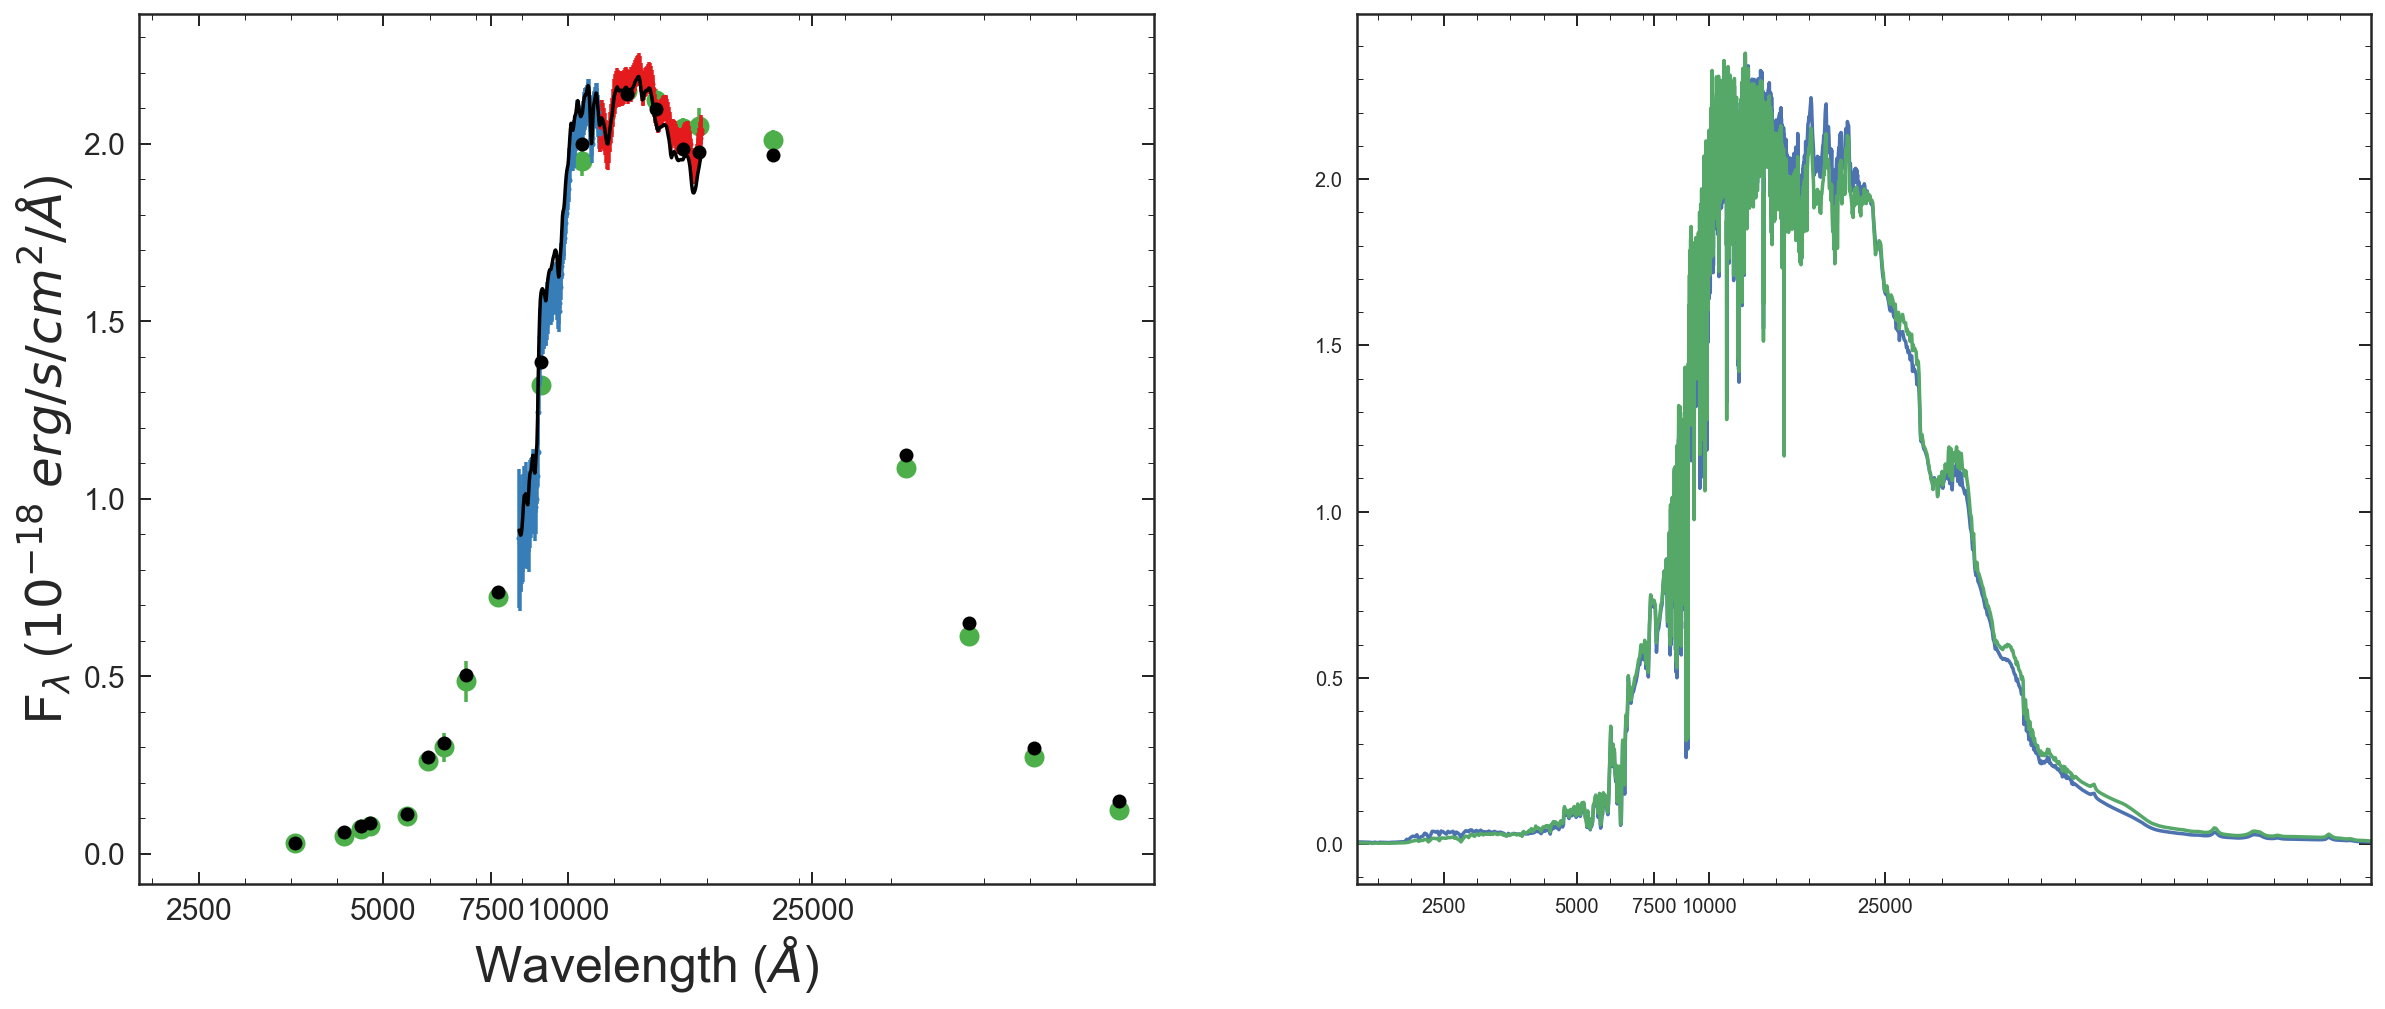

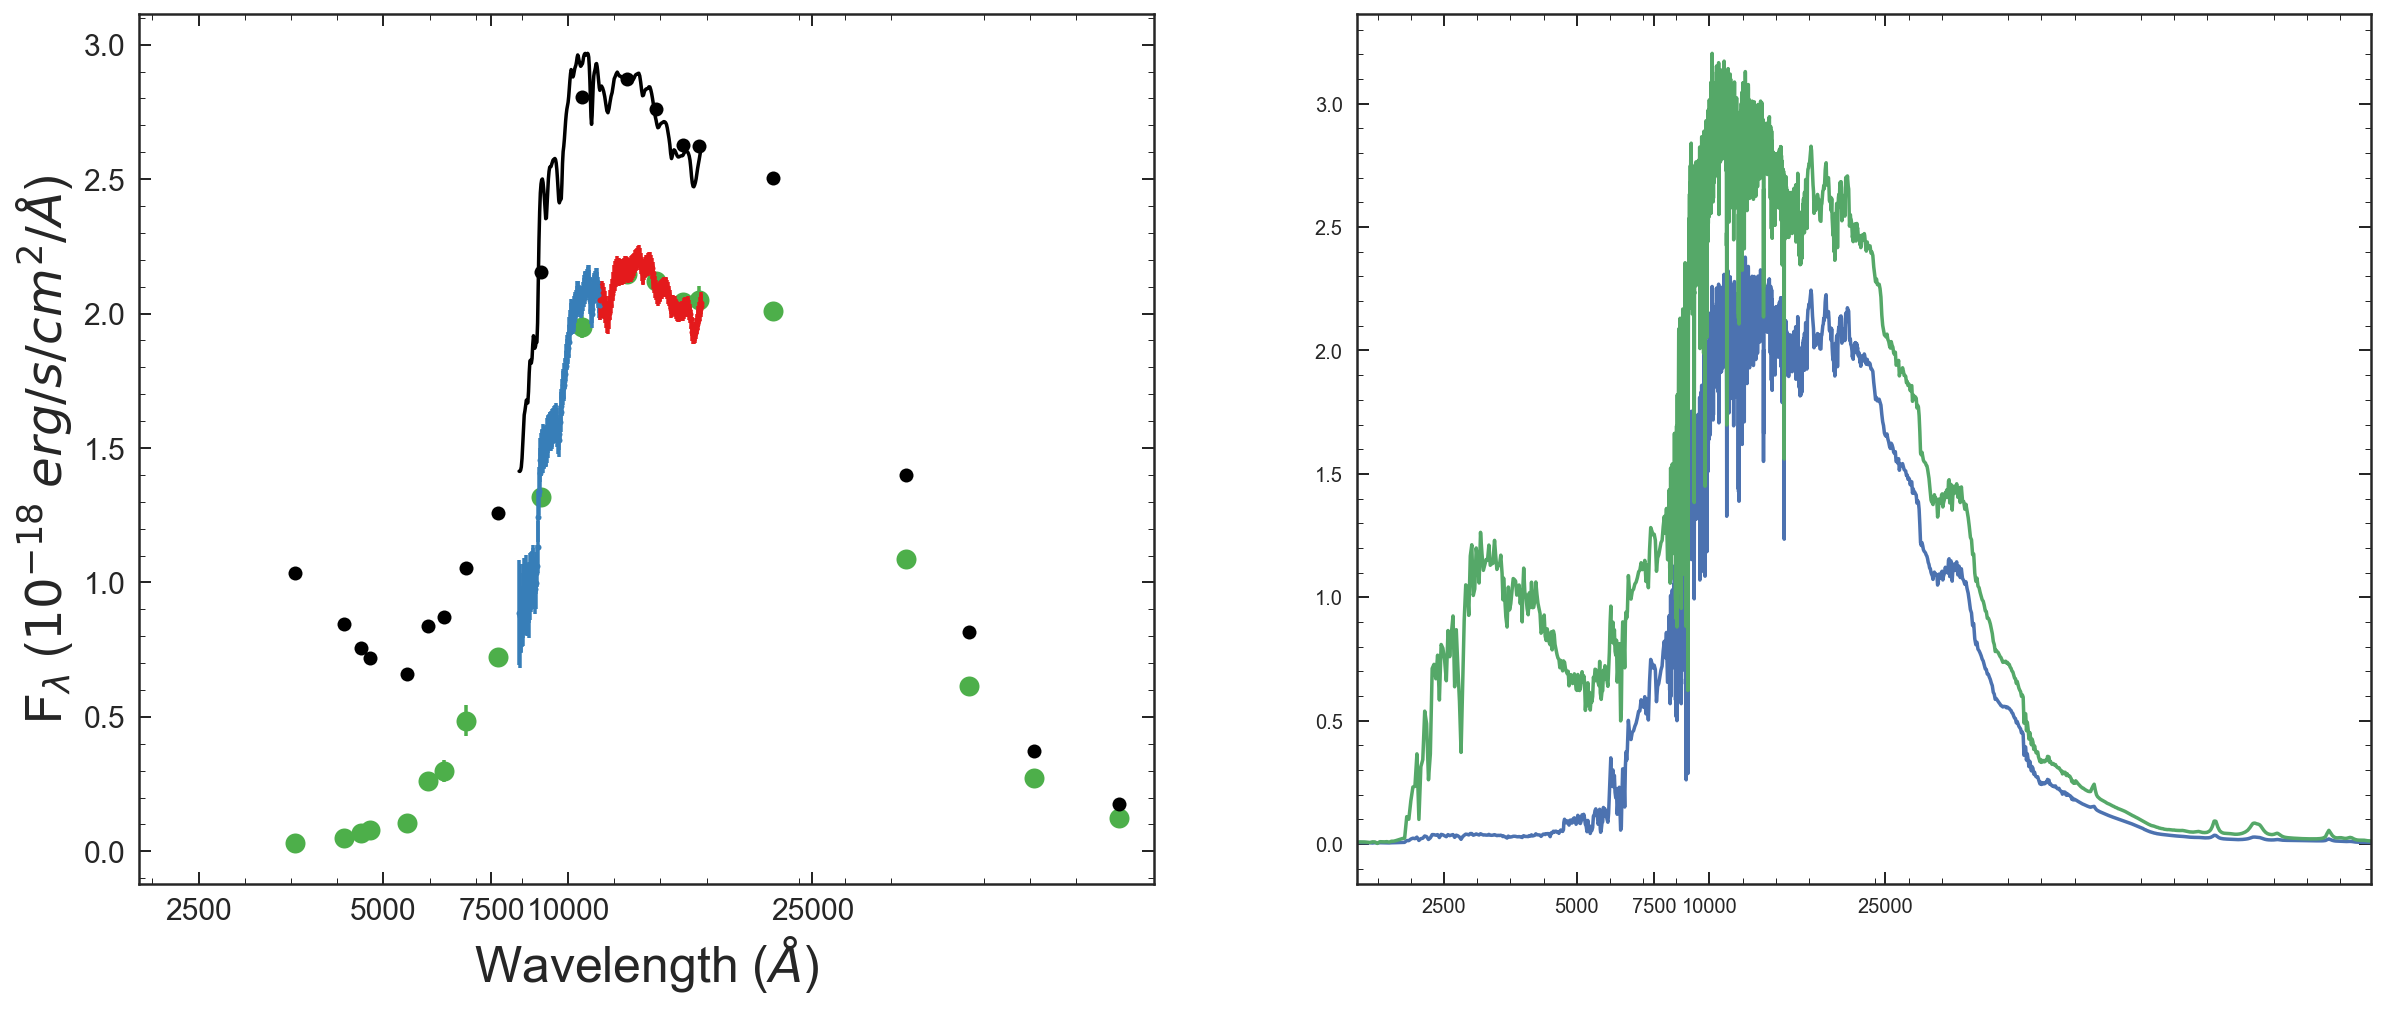

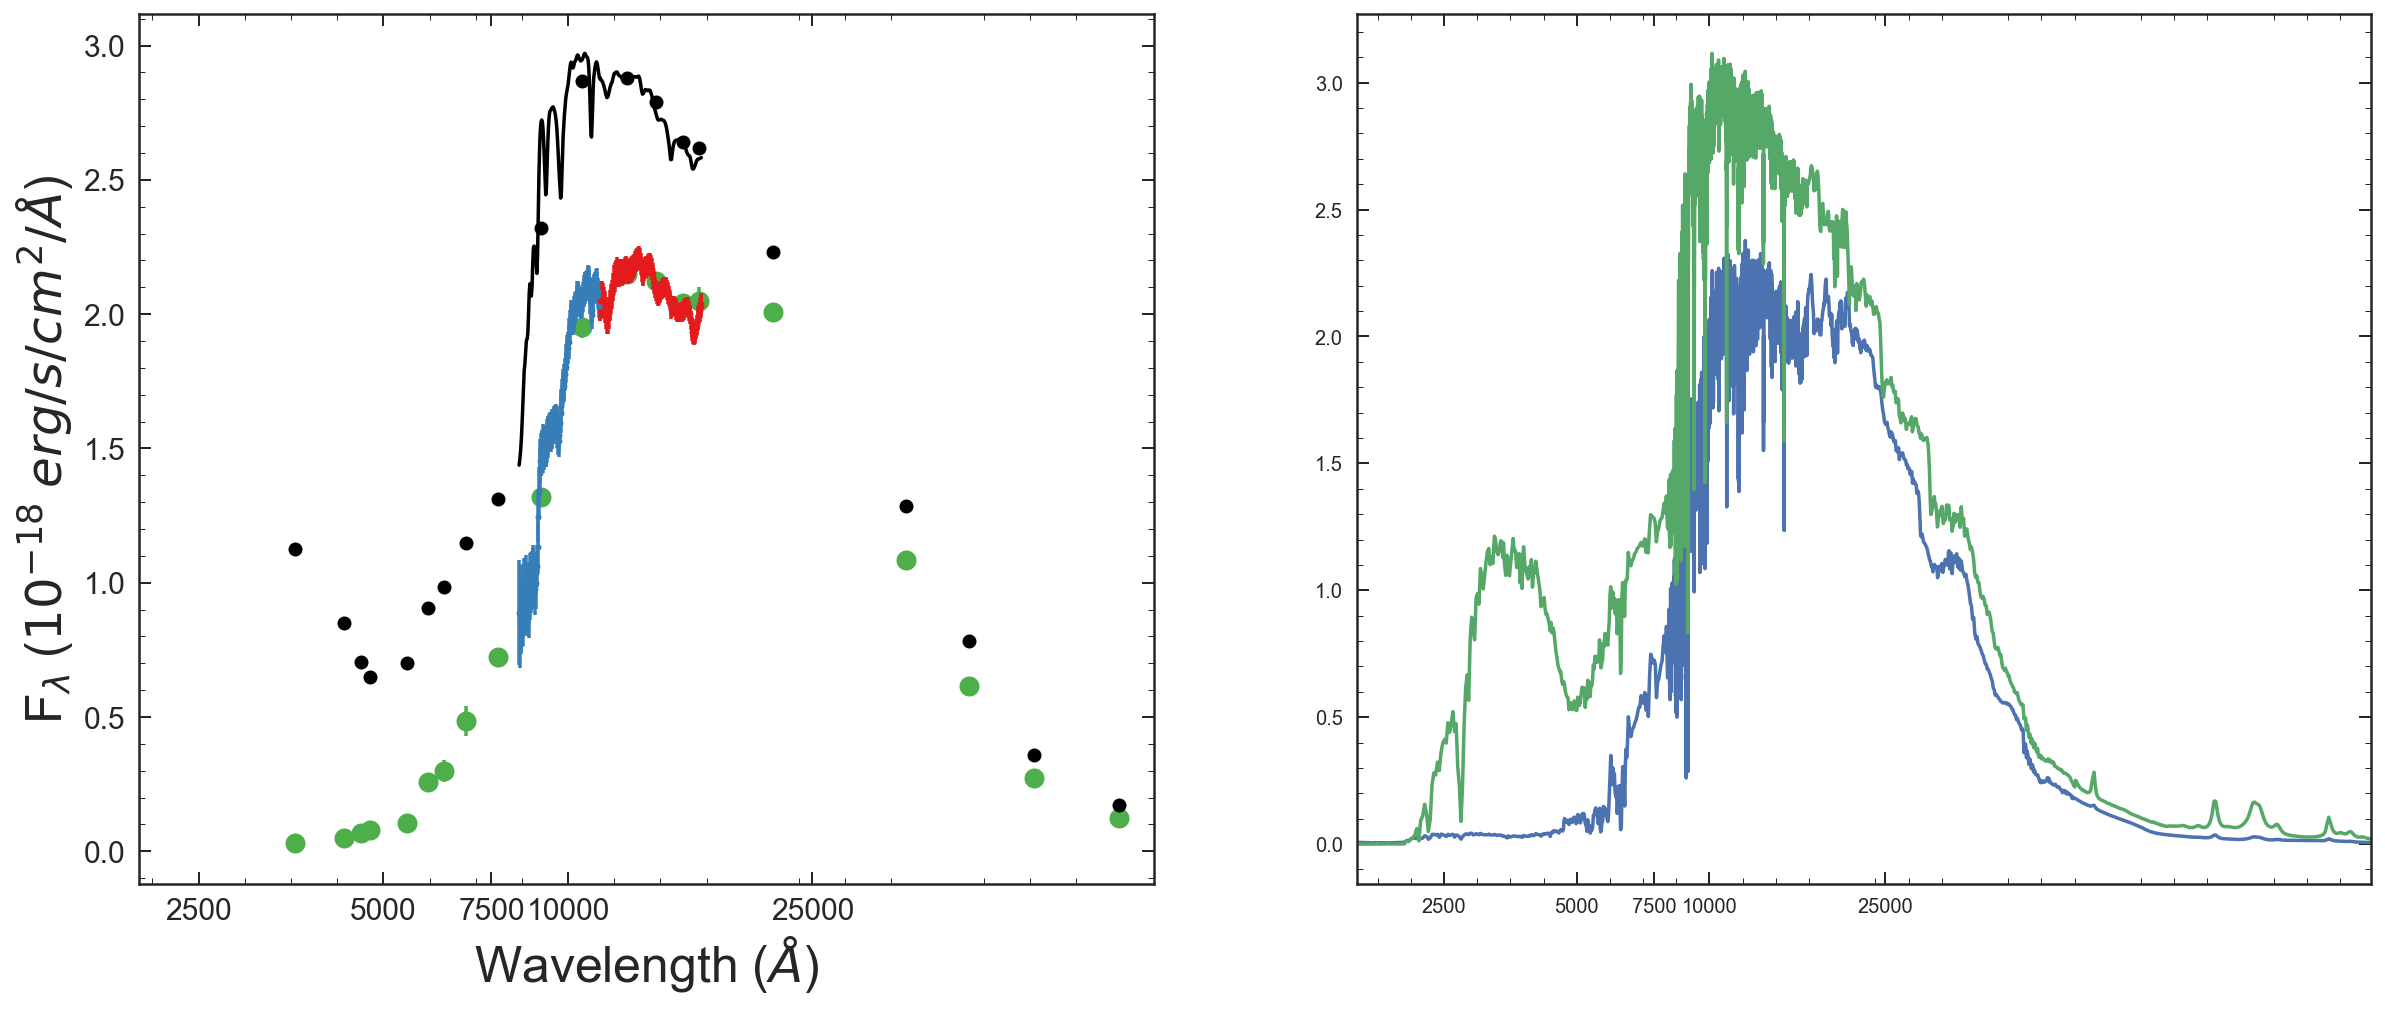

In [29]:
gs = GridSpec(1,2)

sp = fsps.StellarPopulation(imf_type = 2, tpagb_norm_type=0, zcontinuous = 1, logzsol = np.log10(1), sfh = 3, dust_type = 1)

conv = 3.086E24 # Mpc to cm
lsol_to_fsol = 3.839E33 # change L_/odot to F_/odot

D_l = cosmo.luminosity_distance(1.25).value # in Mpc

d_mass_T = 10**11* lsol_to_fsol / (4 * np.pi * (D_l*conv)**2)

for i in range(5):
    dres = np.load('../data/out_dict/sim_test_delay_to_tab_delay_prior{0}.npy'.format(i+1)).item()

    bfZ, bft,bftau1, bftau2, bftau3, bftau4, bftau5, bftau6, bftau7, bftau8, bftau9, bftau10,\
    bfz, bfd, bfm = dres.samples[-1]

    sp.params['dust2'] = bfd
    sp.params['dust1'] = bfd
    sp.params['logzsol'] = np.log10(bfZ)
    sp.set_tabular_sfh(LBT,np.array([bftau1, bftau2, bftau3, bftau4, bftau5, bftau6, bftau7, bftau8, bftau9, bftau10]))

    wavedt, fluxdt = sp.get_spectrum(tage = bft, peraa = True)
    D_l = cosmo.luminosity_distance(bfz).value # in Mpc

    mass_T = (10**bfm / sp.stellar_mass) * lsol_to_fsol / (4 * np.pi * (D_l*conv)**2)  

    sim2.Sim_all_premade(wavedt* (1+bfz), fluxdt * mass_T, scale=False)

    plt.figure(figsize = [20,8])
    plt.subplot(gs[0])

    plt.errorbar(np.log10(sim2.Bwv),sim2.SBfl*1E18,sim2.SBer*1E18,
                    linestyle='None', marker='o', markersize=3, color='#377eb8',zorder = 2, label = 'CLEAR G102')
    plt.errorbar(np.log10(sim2.Rwv),sim2.SRfl*1E18,sim2.SRer*1E18,
                    linestyle='None', marker='o', markersize=3, color='#e41a1c',zorder = 2, label = '3D-HST G141')
    plt.errorbar(np.log10(sim2.Pwv),sim2.SPflx*1E18,sim2.SPerr*1E18,
                                     linestyle='None', marker='o', markersize=10, color='#4daf4a',zorder = 1, label = '3D-HST Photometry')
    plt.plot(np.log10(sim2.Bwv), sim2.Bmfl*1E18, 'k', zorder=5)
    plt.plot(np.log10(sim2.Rwv), sim2.Rmfl*1E18, 'k', zorder=5)
    plt.plot(np.log10(sim2.Pwv), sim2.Pmfl*1E18, 'ko', zorder=5)

    plt.xlim(np.log10(2000), np.log10(90000))

    plt.xticks(np.log10([2500,5000,7500,10000,25000]),[2500,5000,7500,10000,25000])

    plt.xlabel('Wavelength ($\AA$)', fontsize=25)
    plt.ylabel('F$_\lambda$ ($10^{-18}$ $erg/s/cm^{2}/\AA $)', fontsize=25)
    plt.tick_params(axis='both', which='major', labelsize=15)

    plt.subplot(gs[1])

    plt.plot(np.log10(wave2 * (1+specz)), flux2 * d_mass_T*1E18)
    plt.plot(np.log10(wavedt* (1+bfz)), fluxdt * mass_T * 1E18)
    plt.xlim(3.2,5.5)
    plt.xticks(np.log10([2500,5000,7500,10000,25000]),[2500,5000,7500,10000,25000])

    print((sum(((sim2.SBfl - sim2.Bmfl) / sim2.SBer)**2) + sum(((sim2.SRfl - sim2.Rmfl) / sim2.SRer)**2) \
           + sum(((sim2.SPflx - sim2.Pmfl) / sim2.SPerr)**2)) * (-0.5))

In [34]:
specz= 1.25

from prospect.models.transforms import *
lages = [0,8,8.25,8.5,8.75,9,9.25,9.5,9.75,10,10.25]

lagebins = []

for i in range(len(lages)-1):
    lagebins.append([lages[i], lages[i+1]])

upd_lagebins = zred_to_agebins(zred=specz, agebins=lagebins)

LBT2 = (10**upd_lagebins.T[1][::-1][0] - 10**upd_lagebins.T[0][::-1])*1E-9

-335.9711013931561
-296.7855533546633
-231.66735365329575
-70.48566061470667
-312.6339603506392
------------------
-374.04336403403096
-154.45716778259916
-355.018795552277
-269.38456426873927
-345.6159670174862
------------------
-242.34363499564944
-152.20364738216395
-266.3930189977585
-283.9021153165273
-160.27166219693055
------------------
-114.26735837084266
-141.89615220400628
-185.91945597573243
-156.20028002042733
-223.8442799960465


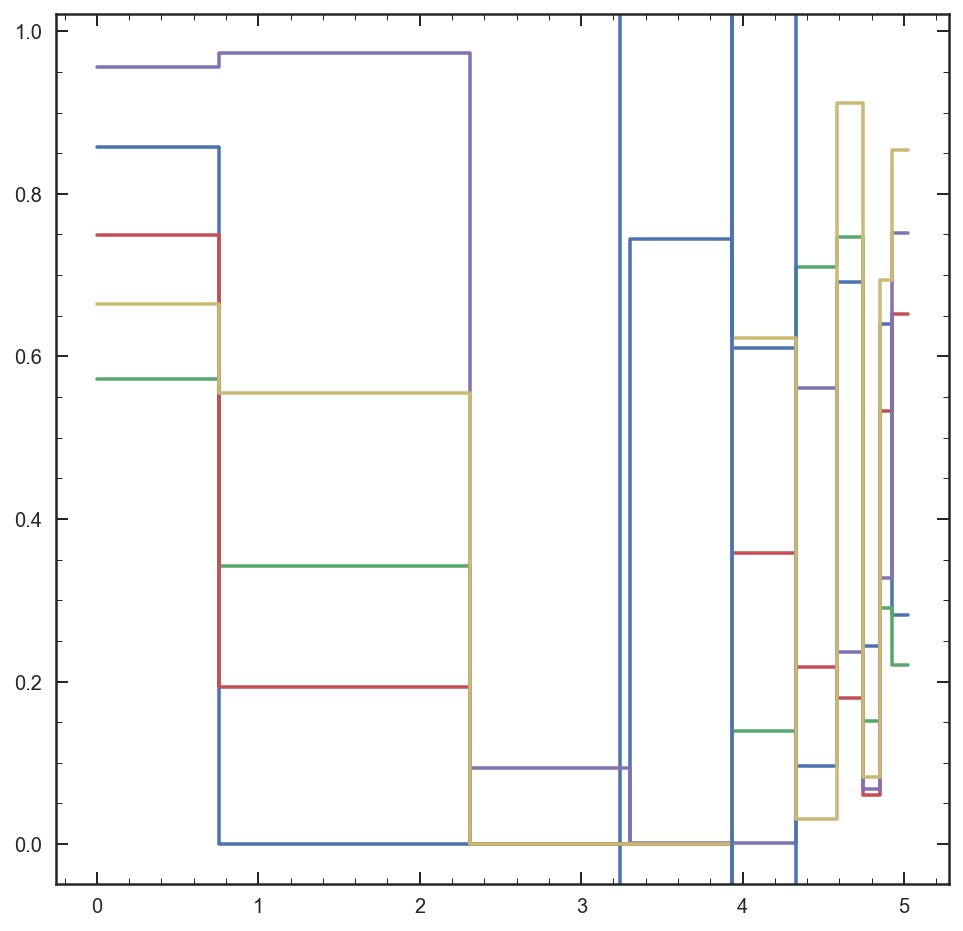

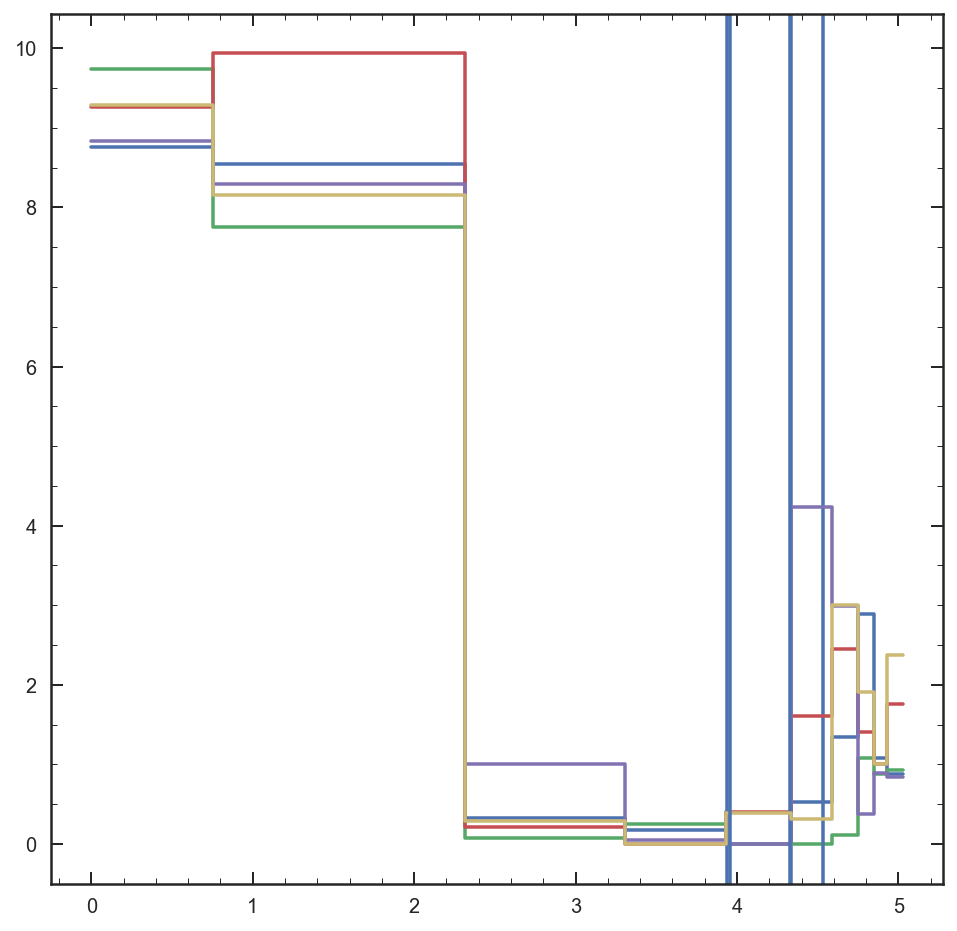

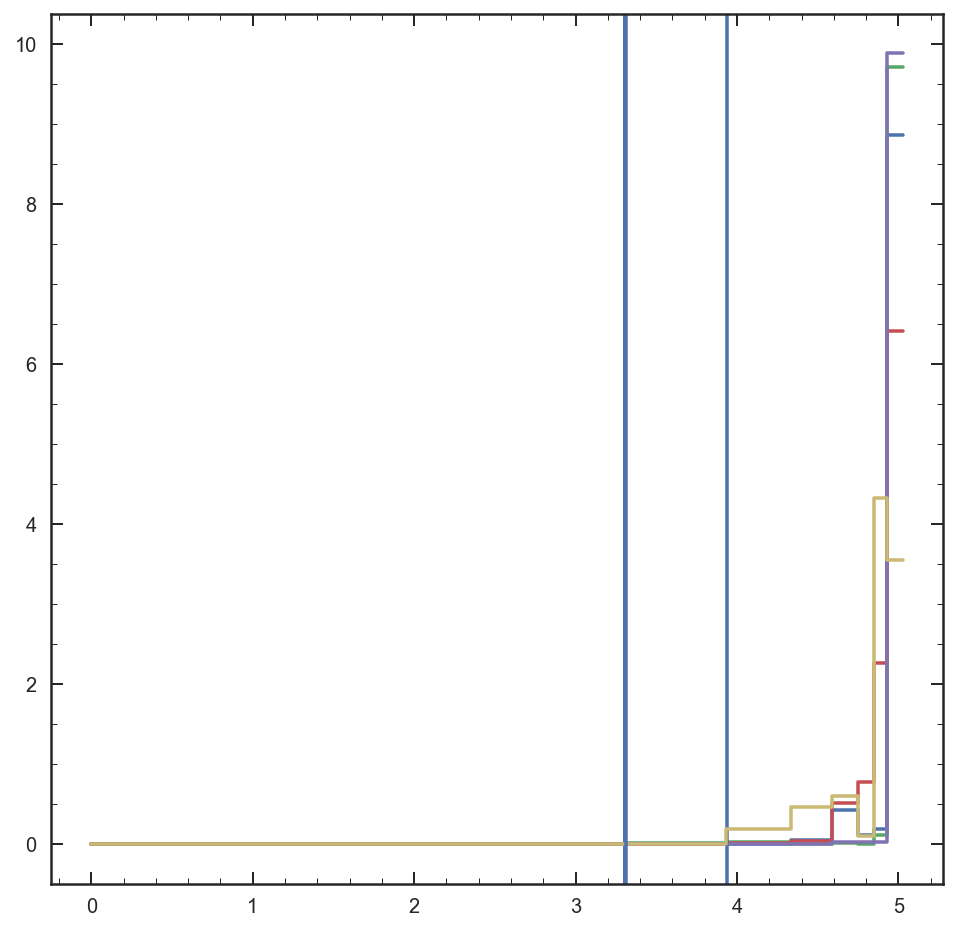

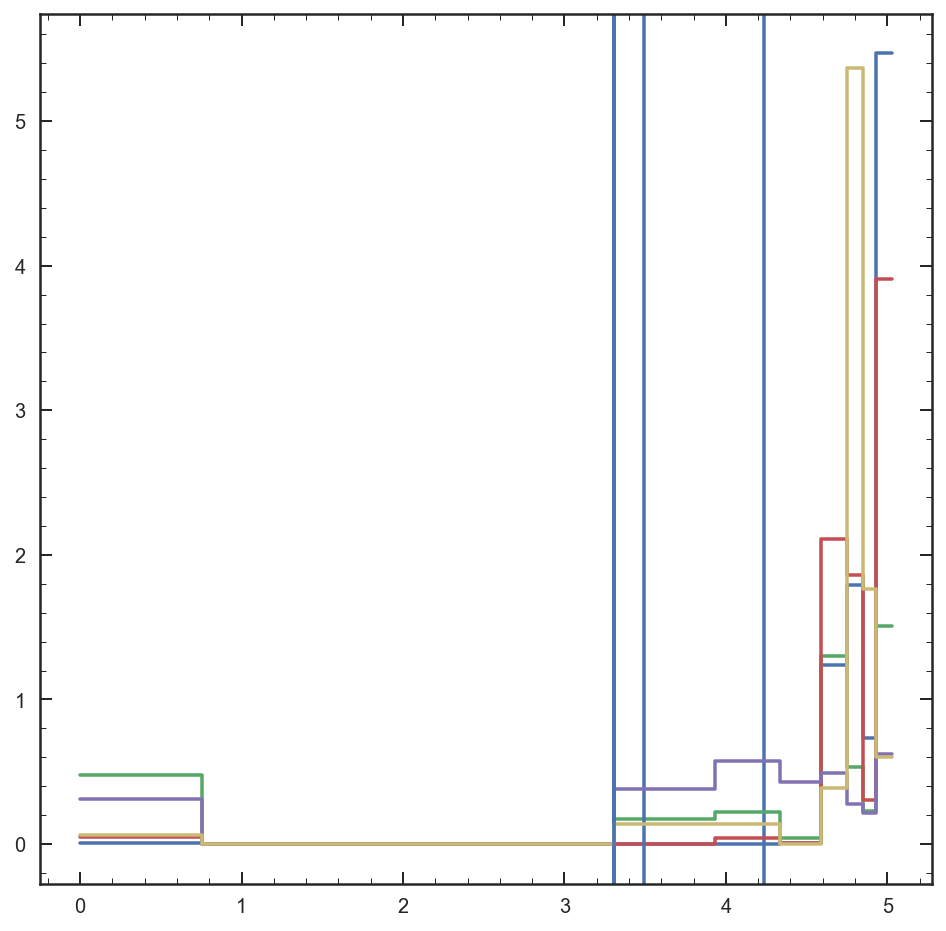

In [26]:
plt.figure(figsize=[8,8])
for i in range(5):
    dres = np.load('../data/out_dict/sim_test_delay_to_tab_no_prior{0}.npy'.format(i+1)).item()
    print(dres.logl[-1])
    bfZ, bft,bftau1, bftau2, bftau3, bftau4, bftau5, bftau6, bftau7, bftau8, bftau9, bftau10,\
    bfz, bfd, bfm = dres.samples[-1]
    plt.step(np.append(0,LBT),[bftau1, bftau1,bftau2, bftau3, bftau4, bftau5, bftau6, bftau7, bftau8, bftau9, bftau10])
    plt.axvline(bft)
    
print('------------------')
    
plt.figure(figsize=[8,8])
for i in range(5):
    dres = np.load('../data/out_dict/sim_test_delay_to_tab_delay_prior{0}.npy'.format(i+1)).item()
    print(dres.logl[-1])
    bfZ, bft,bftau1, bftau2, bftau3, bftau4, bftau5, bftau6, bftau7, bftau8, bftau9, bftau10,\
    bfz, bfd, bfm = dres.samples[-1]
    plt.step(np.append(0,LBT),[bftau1, bftau1,bftau2, bftau3, bftau4, bftau5, bftau6, bftau7, bftau8, bftau9, bftau10])
    plt.axvline(bft)
    
    
print('------------------')

plt.figure(figsize=[8,8])
for i in range(5):
    dres = np.load('../data/out_dict/sim_test_delay_to_tab_dirichlet_prior_a1_{0}.npy'.format(i+1)).item()
    print(dres.logl[-1])
    bfZ, bft,bftau1, bftau2, bftau3, bftau4, bftau5, bftau6, bftau7, bftau8, bftau9, bftau10,\
    bfz, bfd, bfm = dres.samples[-1]
    plt.step(np.append(0,LBT),[bftau1, bftau1,bftau2, bftau3, bftau4, bftau5, bftau6, bftau7, bftau8, bftau9, bftau10])
    plt.axvline(bft)
    
print('------------------')

plt.figure(figsize=[8,8])
for i in range(5):
    dres = np.load('../data/out_dict/sim_test_delay_to_tab_dirichlet_prior_a0.2_{0}.npy'.format(i+1)).item()
    print(dres.logl[-1])
    bfZ, bft,bftau1, bftau2, bftau3, bftau4, bftau5, bftau6, bftau7, bftau8, bftau9, bftau10,\
    bfz, bfd, bfm = dres.samples[-1]
    plt.step(np.append(0,LBT),[bftau1, bftau1,bftau2, bftau3, bftau4, bftau5, bftau6, bftau7, bftau8, bftau9, bftau10])
    plt.axvline(bft)
    

In [35]:
specz= 1.25

from prospect.models.transforms import *
lages = [0,9.0,9.1,9.2,9.3,9.4,9.5,9.6,9.7,9.8,9.9]

lagebins = []

for i in range(len(lages)-1):
    lagebins.append([lages[i], lages[i+1]])

upd_lagebins = zred_to_agebins(zred=specz, agebins=lagebins)

LBT = (10**upd_lagebins.T[1][::-1][0] - 10**upd_lagebins.T[0][::-1])*1E-9

-64.23703706176082
-209.61896265776312
-167.35836842429654
-189.9277184090511
-170.85605427208458
------------------
-284.333461072293
-213.34577769271456
-355.018795552277
-478.4590765784338
-560.0551795667275
------------------
-14.672822203984417
-6.83914391723619
-16.669526054173748
-55.17784087260149
-76.93363723470526
------------------
-359.49736543184576
-571.0312217642071
-518.3131052771143
-361.398555894974
-755.4285901293598
------------------
-3.997019316560724
-1.4108905650027777
-0.3605714330773583
-0.5138456318282864
-3.072313496025277


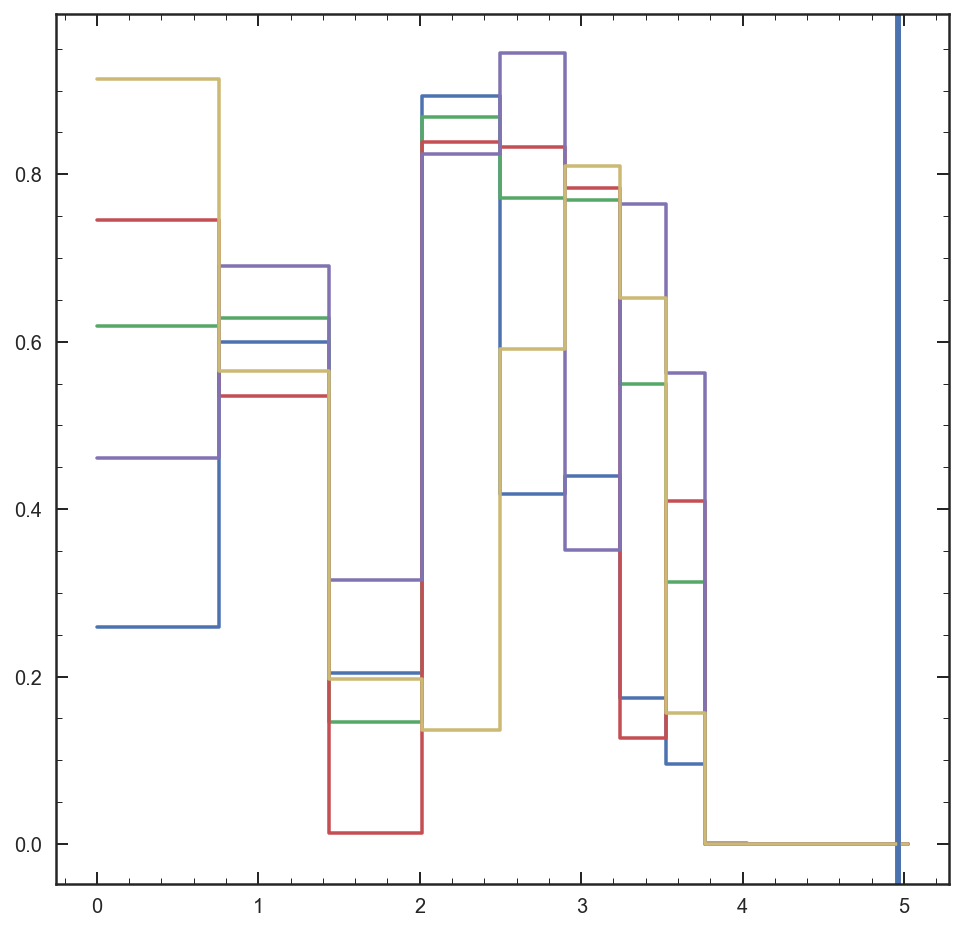

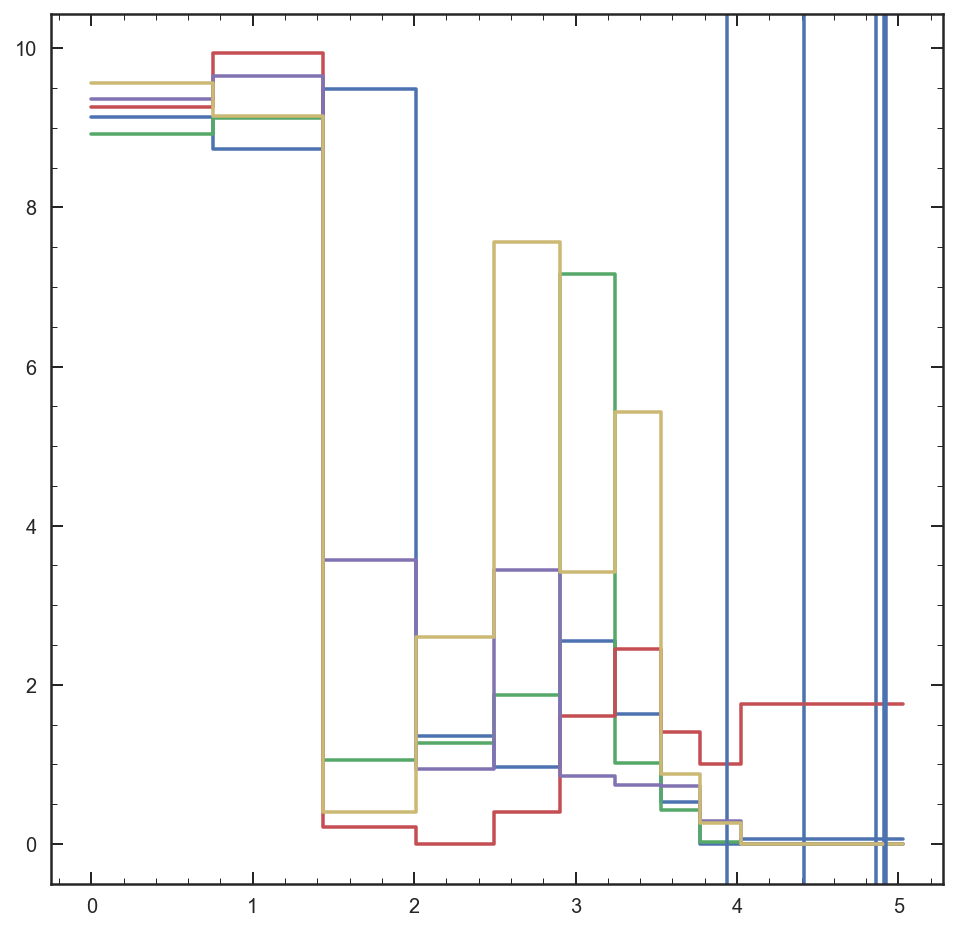

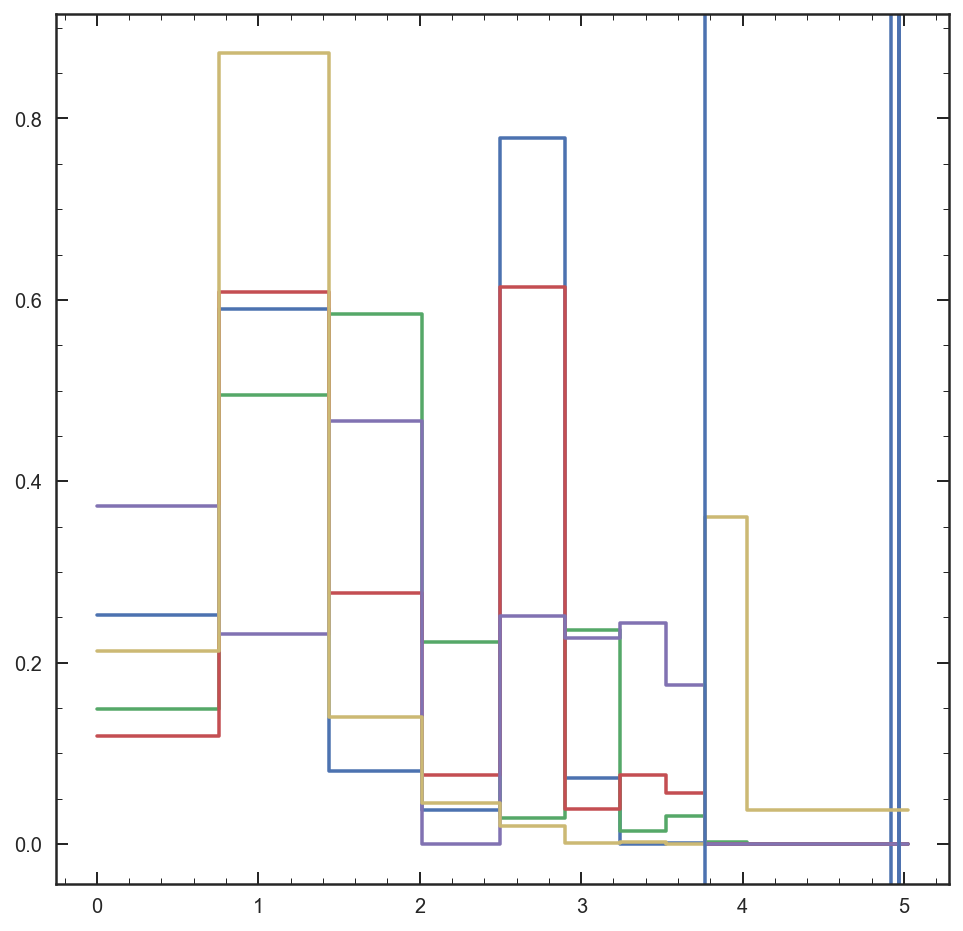

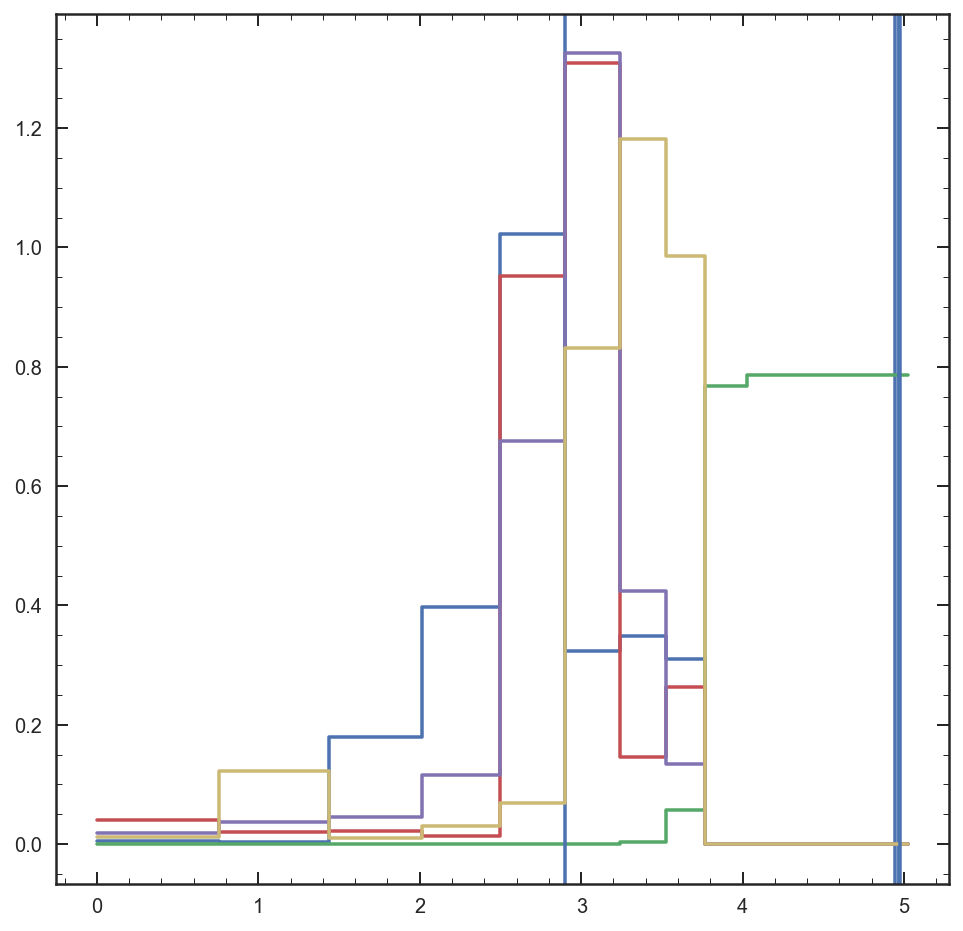

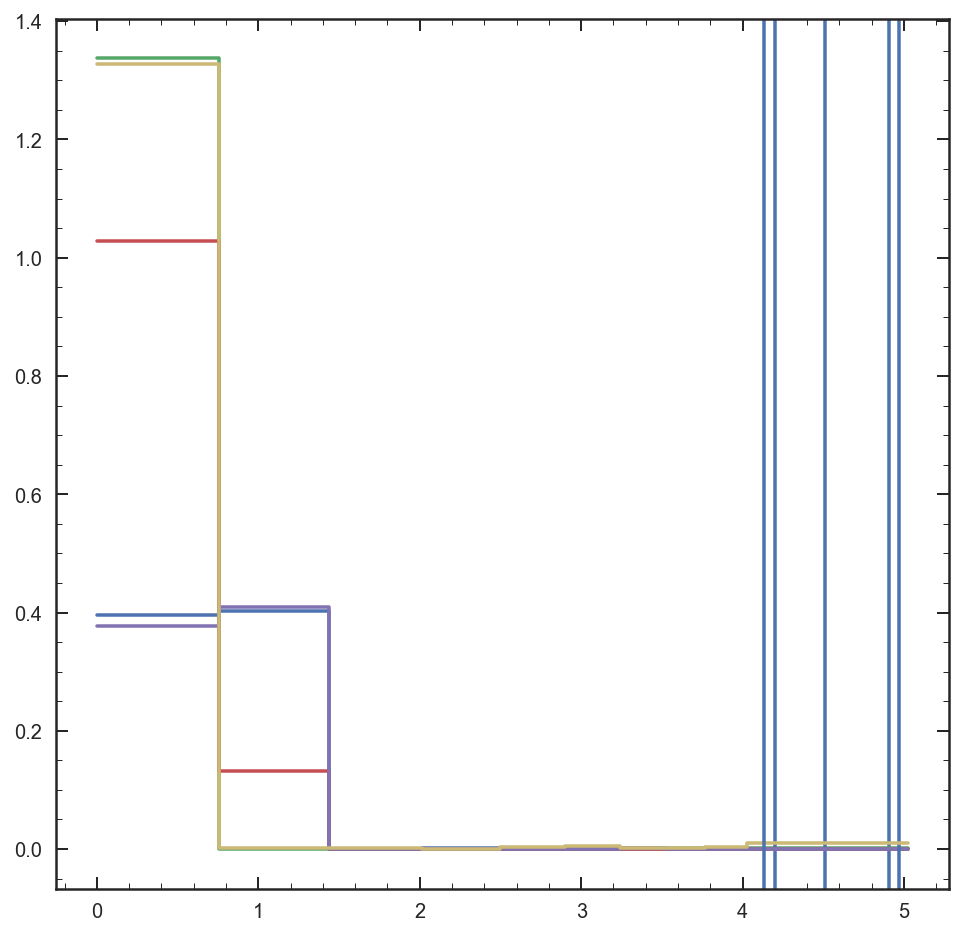

In [41]:
plt.figure(figsize=[8,8])
for i in range(5):
    dres = np.load('../data/out_dict/sim_test_delay_to_tab_no_prior{0}.npy'.format(i+1)).item()
    print(dres.logl[-1])
    bfZ, bft,bftau1, bftau2, bftau3, bftau4, bftau5, bftau6, bftau7, bftau8, bftau9, bftau10,\
    bfz, bfd, bfm = dres.samples[-1]
    plt.step(np.append(0,LBT),[bftau1, bftau1,bftau2, bftau3, bftau4, bftau5, bftau6, bftau7, bftau8, bftau9, bftau10])
    plt.axvline(bft)
    
print('------------------')
    
plt.figure(figsize=[8,8])
for i in range(5):
    dres = np.load('../data/out_dict/sim_test_delay_to_tab_delay_prior{0}.npy'.format(i+1)).item()
    print(dres.logl[-1])
    bfZ, bft,bftau1, bftau2, bftau3, bftau4, bftau5, bftau6, bftau7, bftau8, bftau9, bftau10,\
    bfz, bfd, bfm = dres.samples[-1]
    plt.step(np.append(0,LBT),[bftau1, bftau1,bftau2, bftau3, bftau4, bftau5, bftau6, bftau7, bftau8, bftau9, bftau10])
    plt.axvline(bft)
    
    
print('------------------')

plt.figure(figsize=[8,8])
for i in range(5):
    dres = np.load('../data/out_dict/sim_test_delay_to_tab_dirichlet_prior_a1_{0}.npy'.format(i+1)).item()
    print(dres.logl[-1])
    bfZ, bft,bftau1, bftau2, bftau3, bftau4, bftau5, bftau6, bftau7, bftau8, bftau9, bftau10,\
    bfz, bfd, bfm = dres.samples[-1]
    plt.step(np.append(0,LBT),[bftau1, bftau1,bftau2, bftau3, bftau4, bftau5, bftau6, bftau7, bftau8, bftau9, bftau10])
    plt.axvline(bft)
    
print('------------------')

plt.figure(figsize=[8,8])
for i in range(5):
    dres = np.load('../data/out_dict/sim_test_delay_to_tab_dirichlet_prior_a0.2_{0}.npy'.format(i+1)).item()
    print(dres.logl[-1])
    bfZ, bft,bftau1, bftau2, bftau3, bftau4, bftau5, bftau6, bftau7, bftau8, bftau9, bftau10,\
    bfz, bfd, bfm = dres.samples[-1]
    plt.step(np.append(0,LBT),[bftau1, bftau1,bftau2, bftau3, bftau4, bftau5, bftau6, bftau7, bftau8, bftau9, bftau10])
    plt.axvline(bft)

print('------------------')

plt.figure(figsize=[8,8])
for i in range(5):
    dres = np.load('../data/out_dict/sim_test_delay_to_tab_continuity_prior_{0}.npy'.format(i+1)).item()
    print(dres.logl[-1])
    bfZ, bft,bftau1, bftau2, bftau3, bftau4, bftau5, bftau6, bftau7, bftau8, bftau9, bftau10,\
    bfz, bfd, bfm = dres.samples[-1]
    plt.step(np.append(0,LBT),[bftau1, bftau1,bftau2, bftau3, bftau4, bftau5, bftau6, bftau7, bftau8, bftau9, bftau10])
    plt.axvline(bft)

In [36]:
LBT2

array([0.75411443, 2.314036  , 3.30452722, 3.9334517 , 4.33279497,
       4.58636285, 4.74736887, 4.8496016 , 4.92742954, 5.02742954])

In [37]:
LBT

array([0.75411443, 1.4386948 , 2.01360615, 2.49641734, 2.9018827 ,
       3.24239296, 3.52835386, 3.76850413, 4.02742954, 5.02742954])

In [39]:
all_logl = []
for i in range(5):
    dres = np.load('../data/out_dict/sim_test_delay_to_tab_no_prior{0}.npy'.format(i+1)).item()
    all_logl.append(dres.logl[-1])
print(np.mean(all_logl))
    
print('------------------')
    
all_logl = []
for i in range(5):
    dres = np.load('../data/out_dict/sim_test_delay_to_tab_delay_prior{0}.npy'.format(i+1)).item()
    all_logl.append(dres.logl[-1])
print(np.mean(all_logl))
    
print('------------------')

all_logl = []
for i in range(5):
    dres = np.load('../data/out_dict/sim_test_delay_to_tab_dirichlet_prior_a1_{0}.npy'.format(i+1)).item()
    all_logl.append(dres.logl[-1])
print(np.mean(all_logl))
    
print('------------------')

all_logl = []
for i in range(5):
    dres = np.load('../data/out_dict/sim_test_delay_to_tab_dirichlet_prior_a0.2_{0}.npy'.format(i+1)).item()
    all_logl.append(dres.logl[-1])
print(np.mean(all_logl))
    
print('------------------')

all_logl = []
for i in range(5):
    dres = np.load('../data/out_dict/sim_test_delay_to_tab_continuity_prior_{0}.npy'.format(i+1)).item()
    all_logl.append(dres.logl[-1])
print(np.mean(all_logl))

-160.39962816499124
------------------
-378.24245809248913
------------------
-201.86095359583683
------------------
-513.1337676995001
------------------
-1.8709280884988846


-365.57815475690603
-576.2007843595759
-523.299158361242
-367.39592694846385
-762.1479731244757


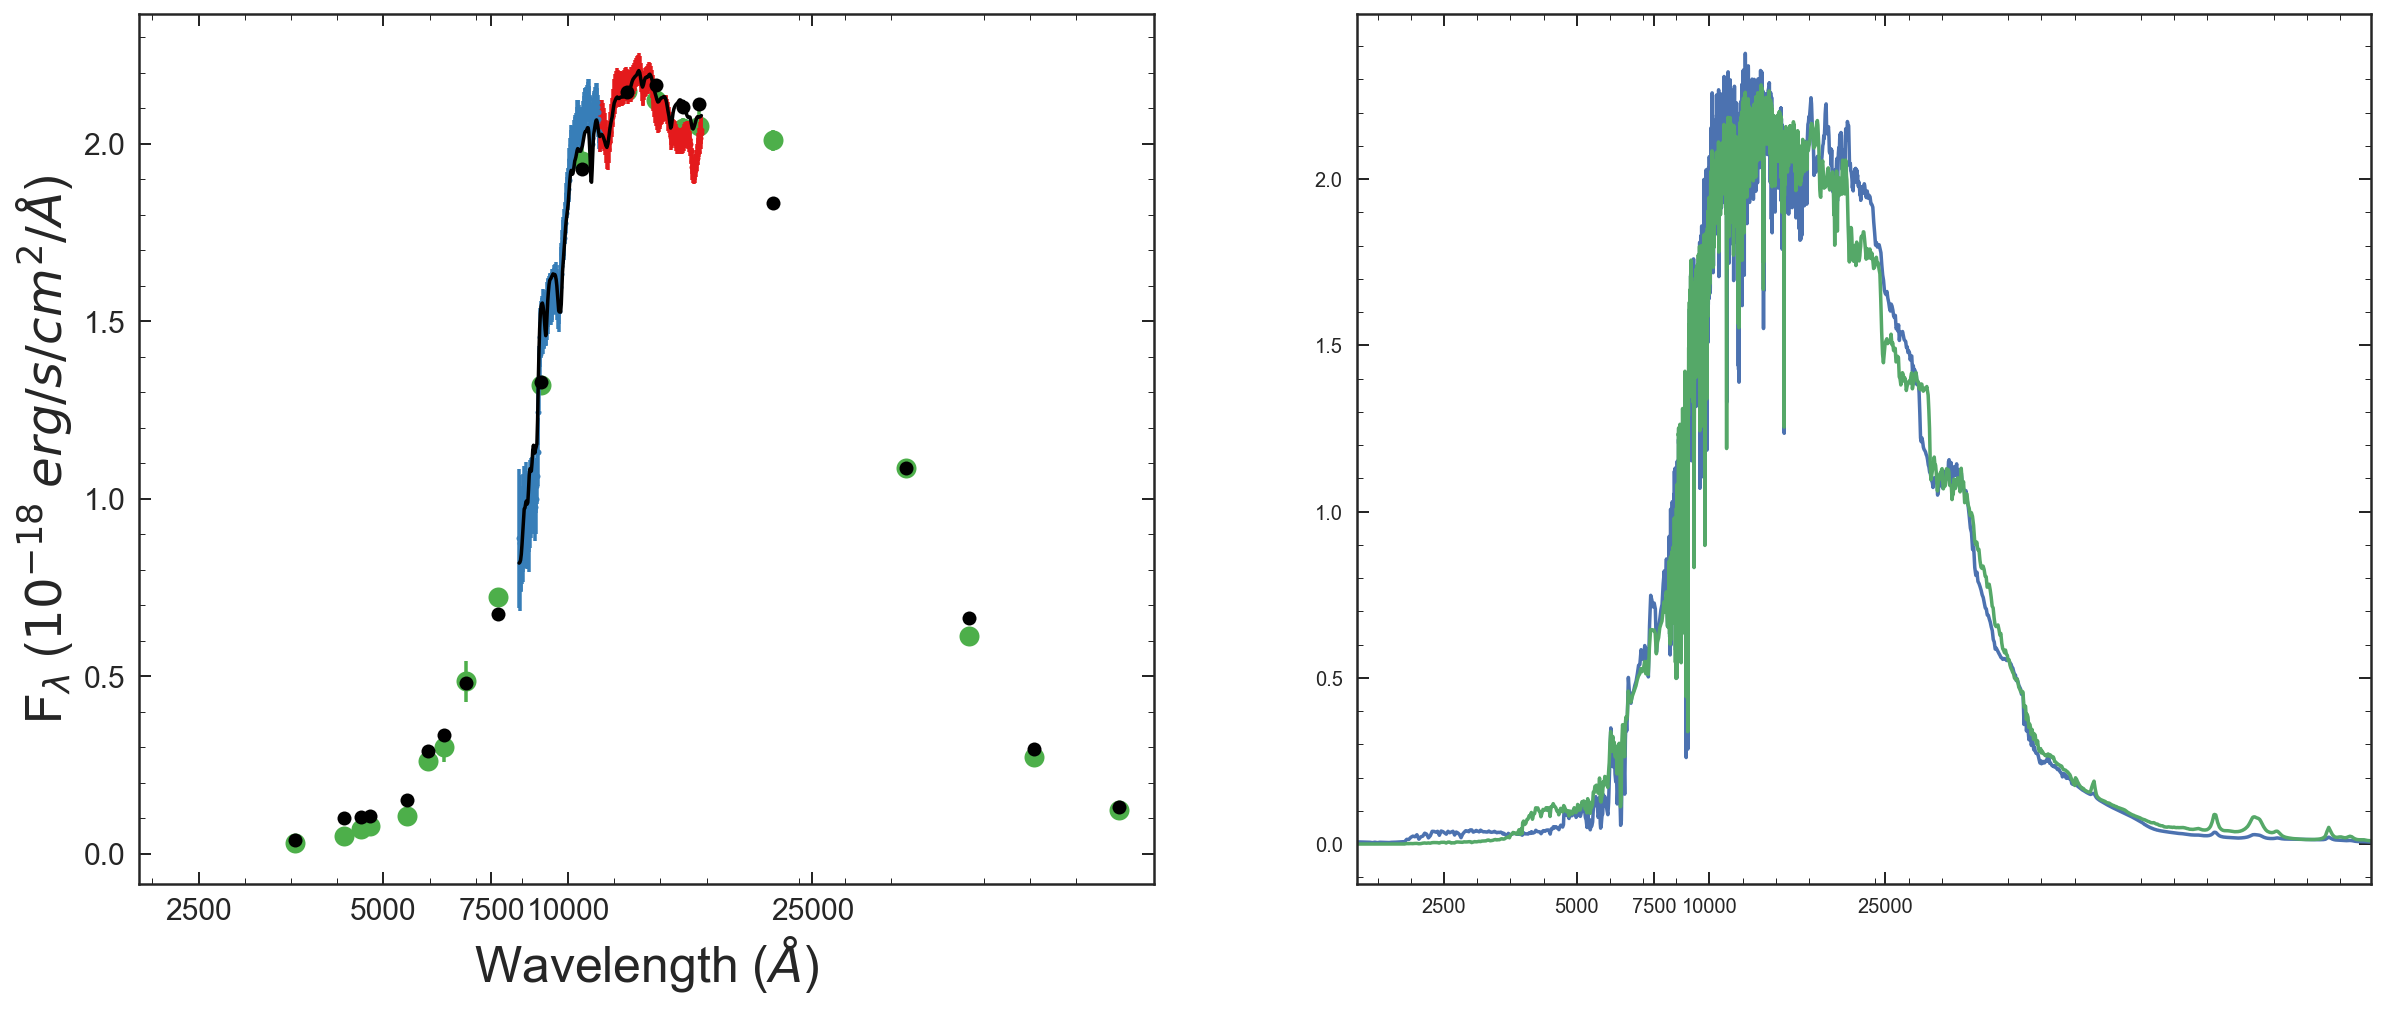

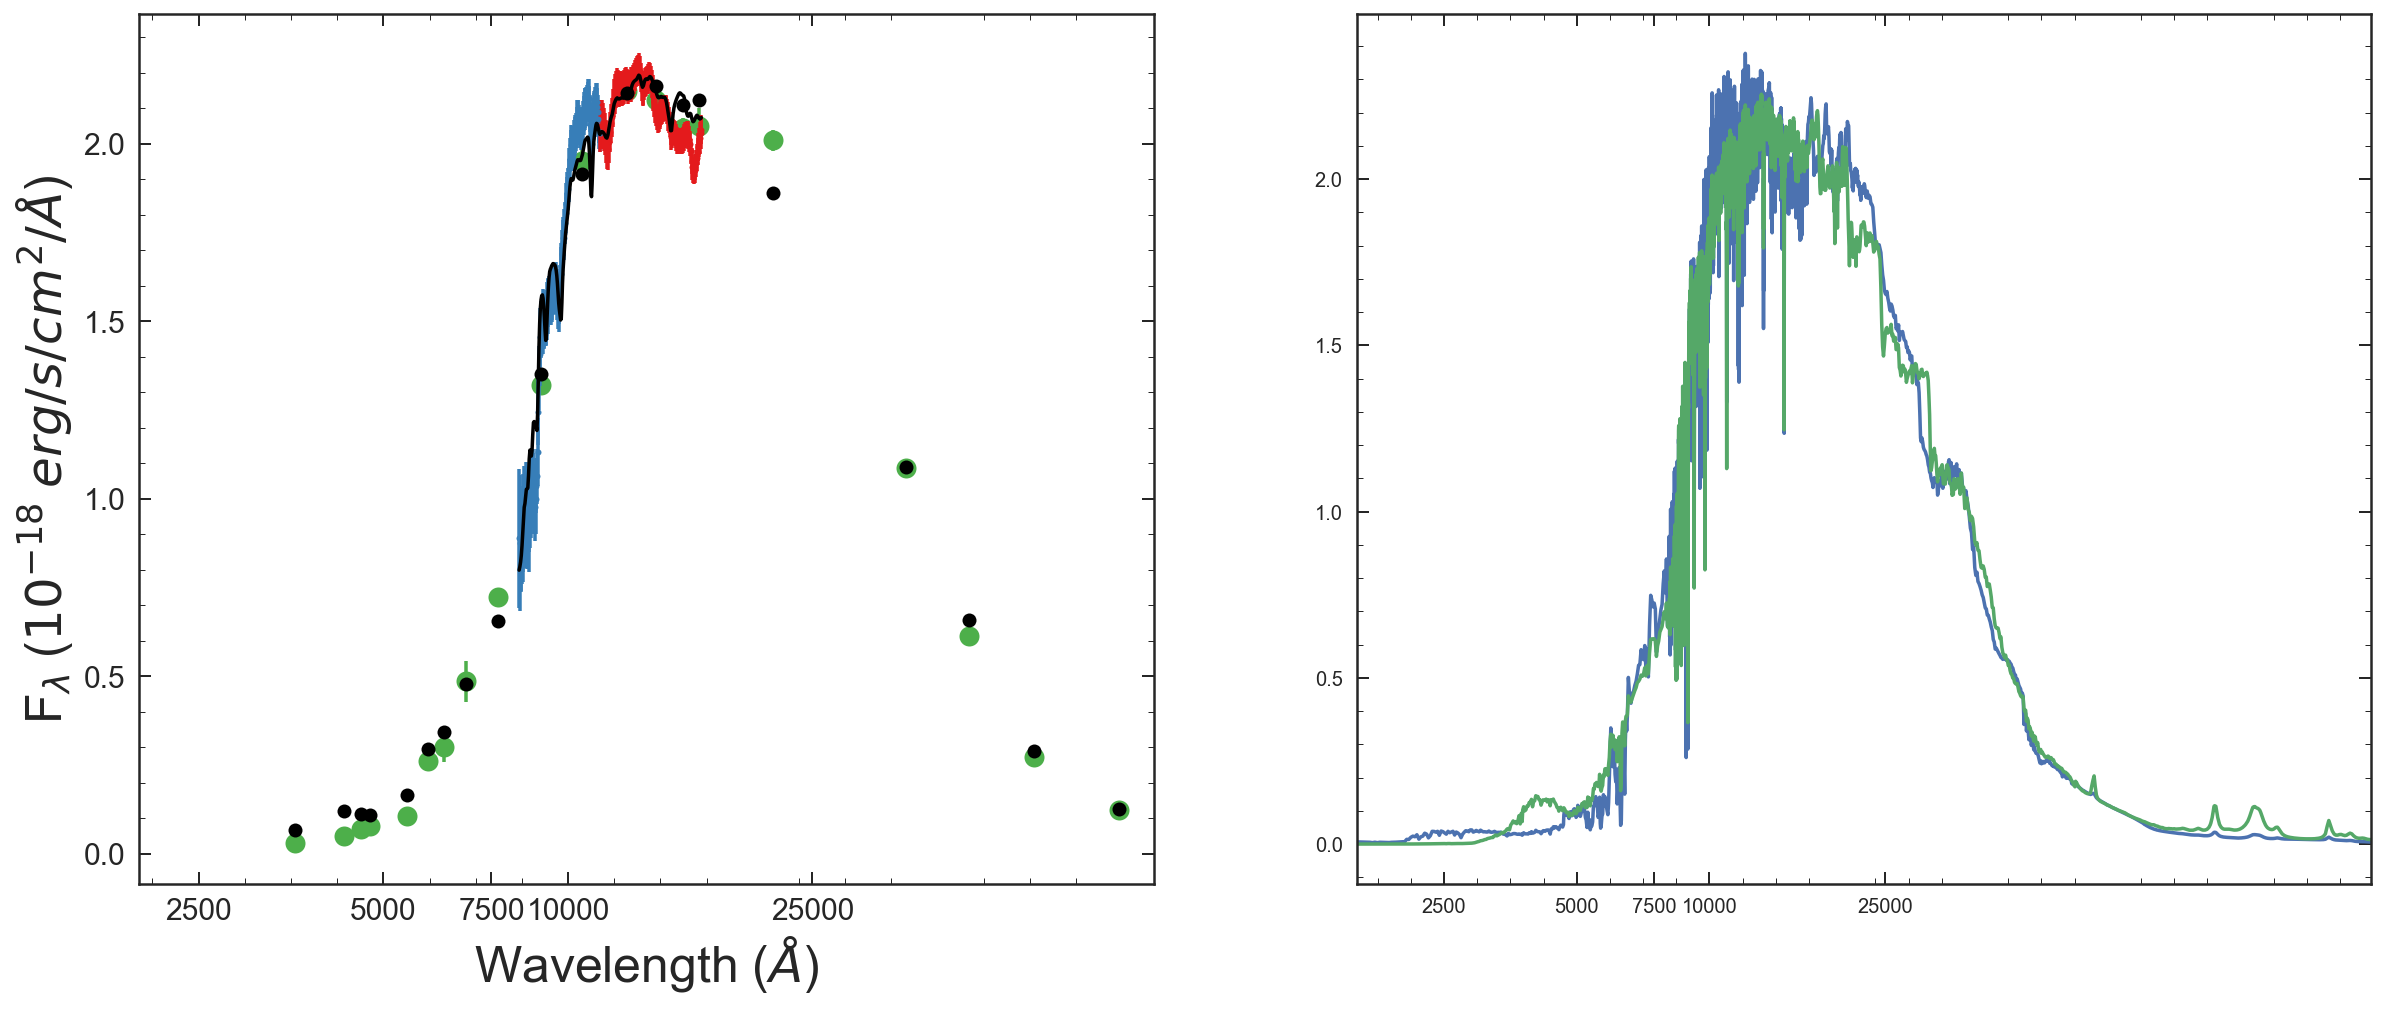

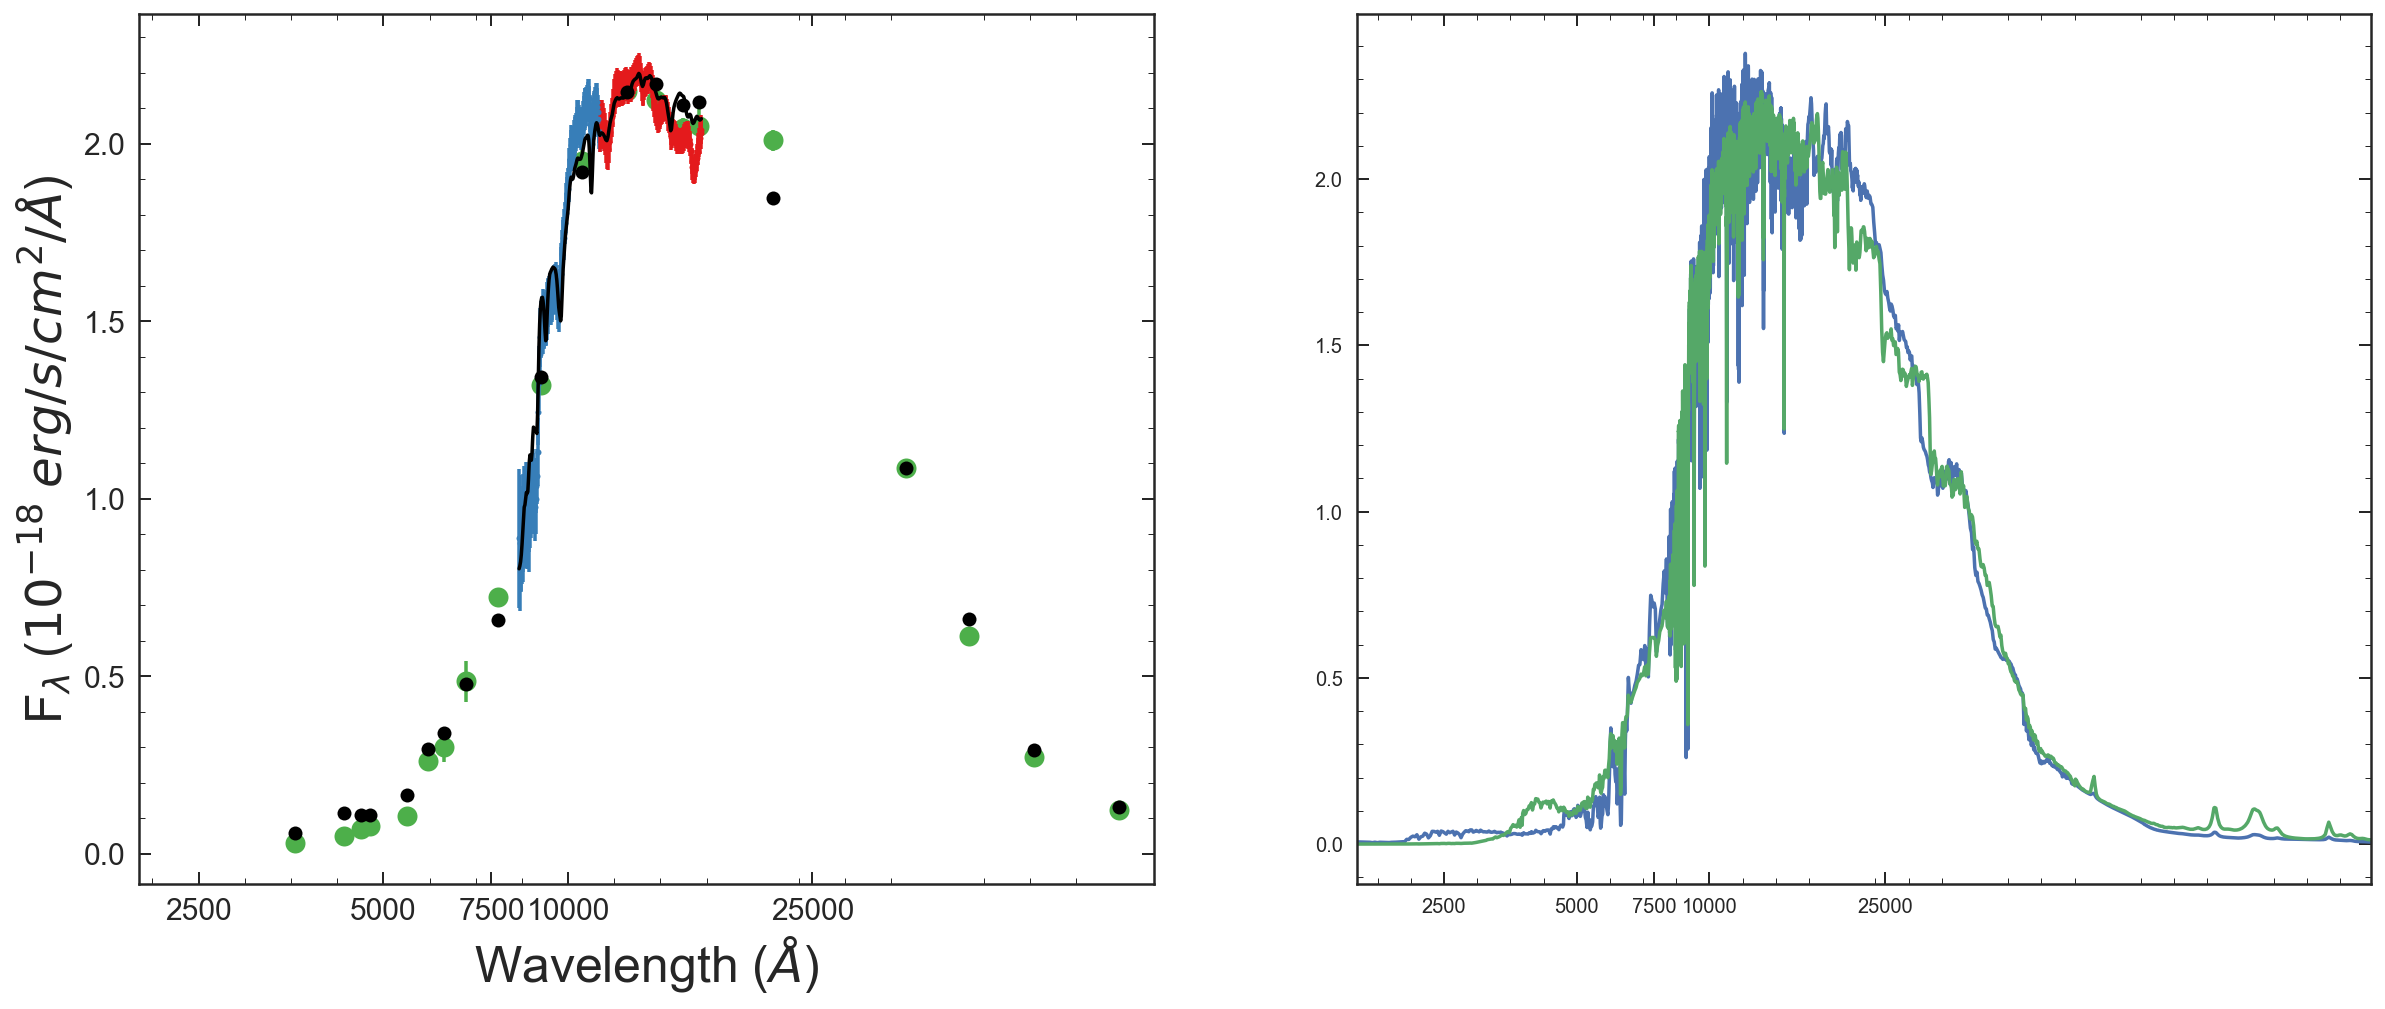

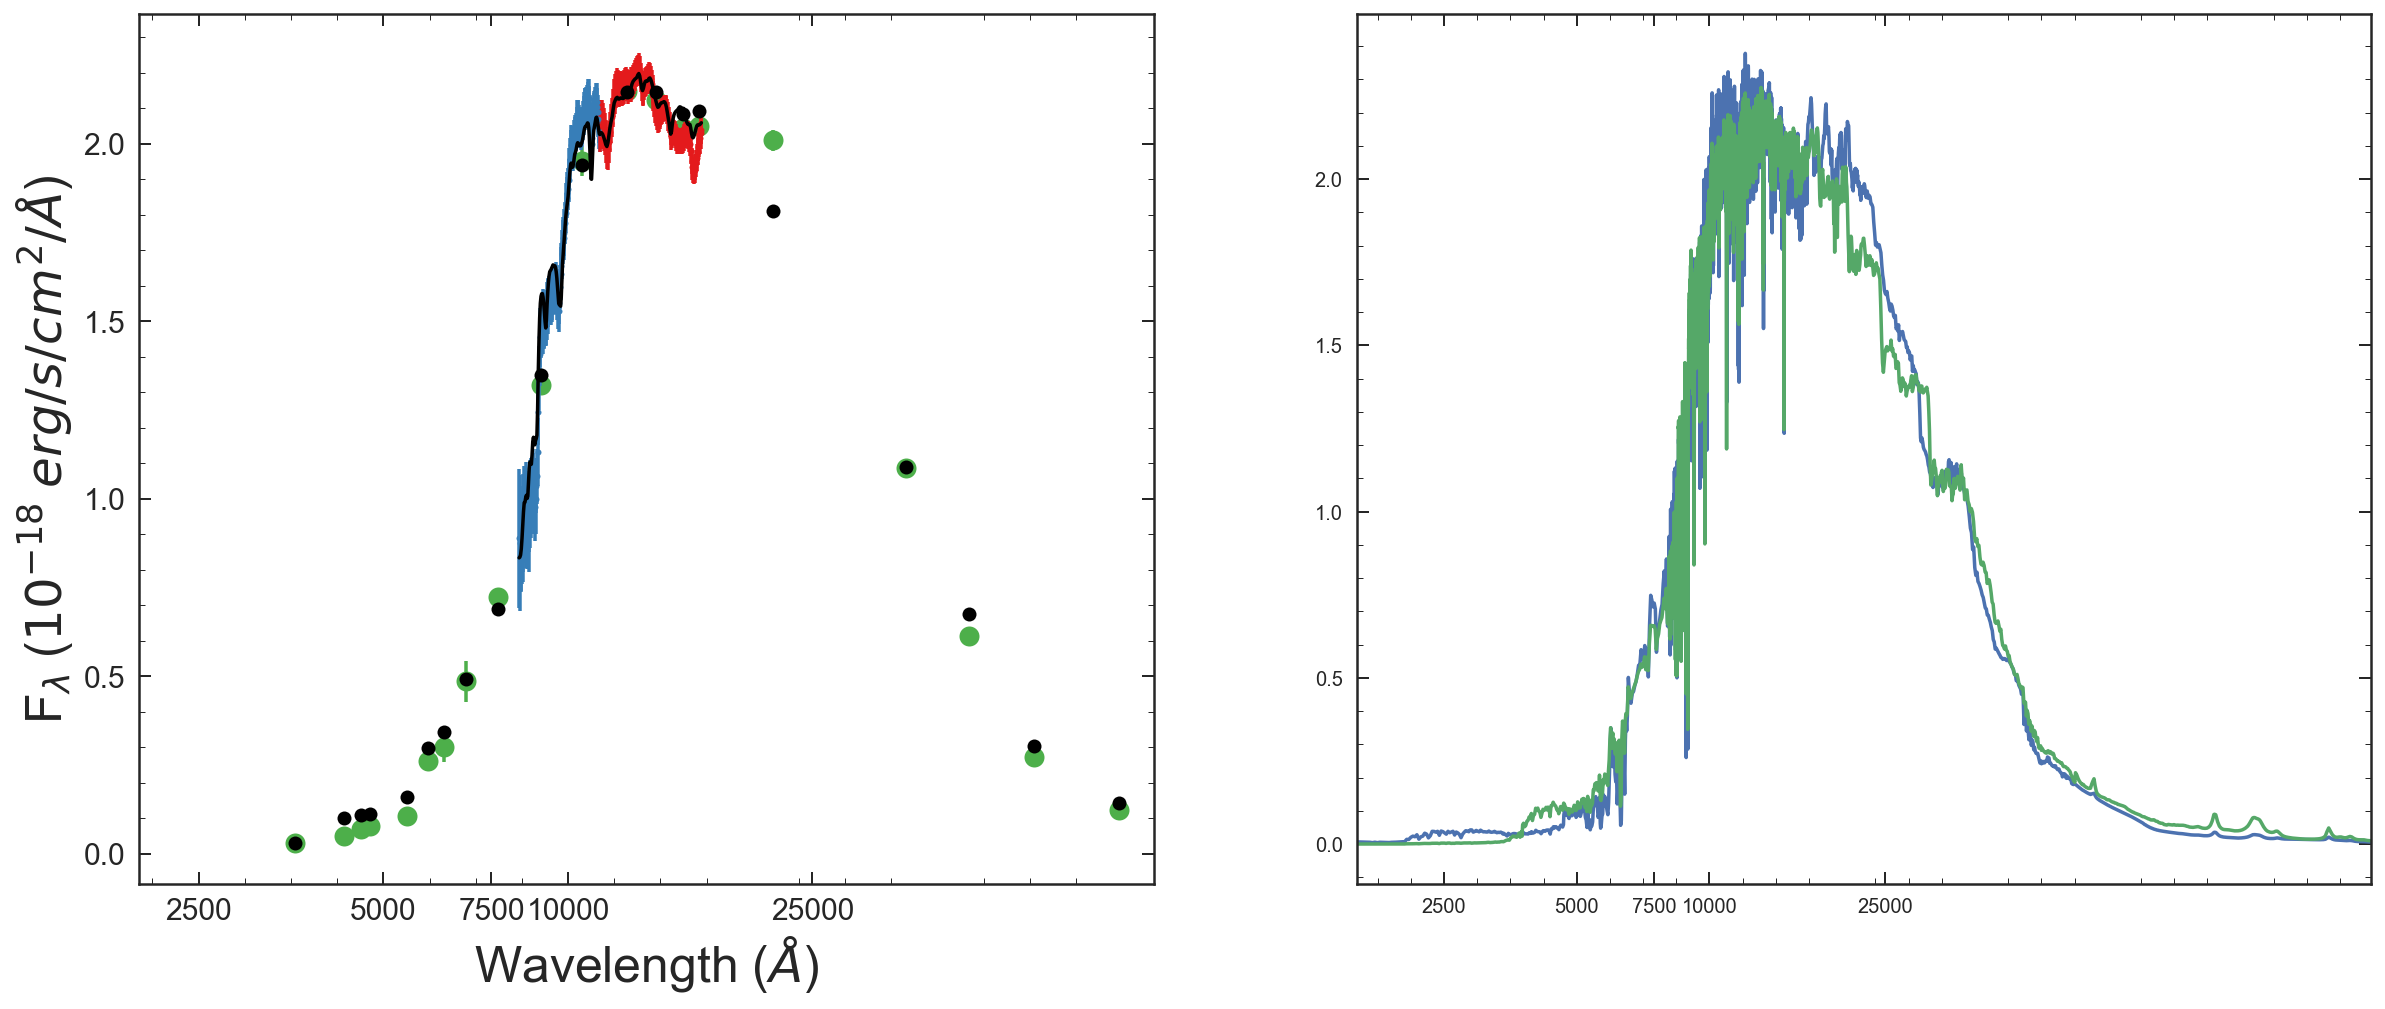

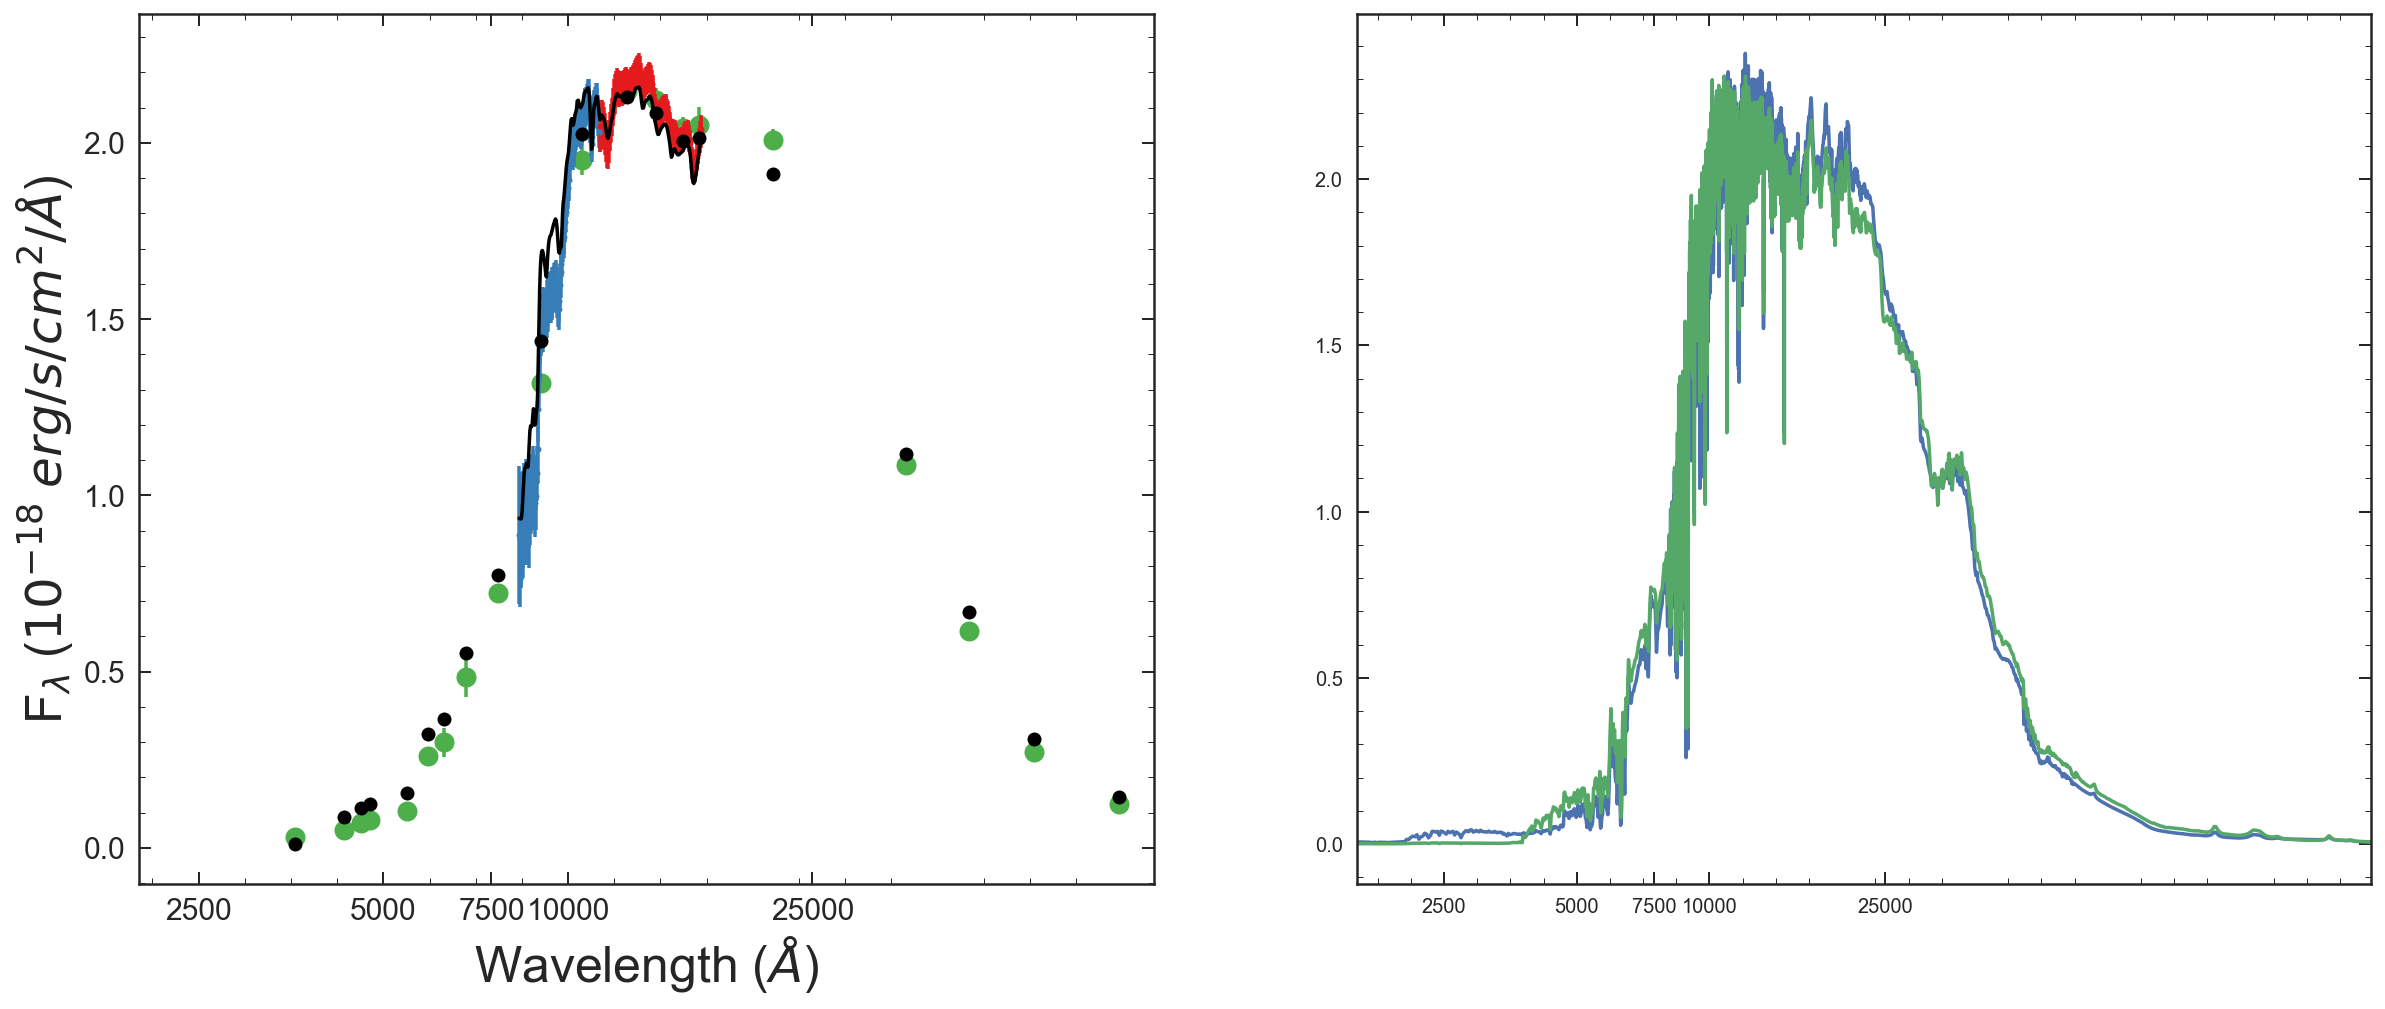

In [33]:
gs = GridSpec(1,2)

sp = fsps.StellarPopulation(imf_type = 2, tpagb_norm_type=0, zcontinuous = 1, logzsol = np.log10(1), sfh = 3, dust_type = 1)

conv = 3.086E24 # Mpc to cm
lsol_to_fsol = 3.839E33 # change L_/odot to F_/odot

D_l = cosmo.luminosity_distance(1.25).value # in Mpc

d_mass_T = 10**11* lsol_to_fsol / (4 * np.pi * (D_l*conv)**2)

for i in range(5):
    dres = np.load('../data/out_dict/sim_test_delay_to_tab_dirichlet_prior_a0.2_{0}.npy'.format(i+1)).item()

    bfZ, bft,bftau1, bftau2, bftau3, bftau4, bftau5, bftau6, bftau7, bftau8, bftau9, bftau10,\
    bfz, bfd, bfm = dres.samples[-1]

    sp.params['dust2'] = bfd
    sp.params['dust1'] = bfd
    sp.params['logzsol'] = np.log10(bfZ)
    sp.set_tabular_sfh(LBT,np.array([bftau1, bftau2, bftau3, bftau4, bftau5, bftau6, bftau7, bftau8, bftau9, bftau10]))

    wavedt, fluxdt = sp.get_spectrum(tage = bft, peraa = True)
    D_l = cosmo.luminosity_distance(bfz).value # in Mpc

    mass_T = (10**bfm / sp.stellar_mass) * lsol_to_fsol / (4 * np.pi * (D_l*conv)**2)  

    sim2.Sim_all_premade(wavedt* (1+bfz), fluxdt * mass_T, scale=False)

    plt.figure(figsize = [20,8])
    plt.subplot(gs[0])

    plt.errorbar(np.log10(sim2.Bwv),sim2.SBfl*1E18,sim2.SBer*1E18,
                    linestyle='None', marker='o', markersize=3, color='#377eb8',zorder = 2, label = 'CLEAR G102')
    plt.errorbar(np.log10(sim2.Rwv),sim2.SRfl*1E18,sim2.SRer*1E18,
                    linestyle='None', marker='o', markersize=3, color='#e41a1c',zorder = 2, label = '3D-HST G141')
    plt.errorbar(np.log10(sim2.Pwv),sim2.SPflx*1E18,sim2.SPerr*1E18,
                                     linestyle='None', marker='o', markersize=10, color='#4daf4a',zorder = 1, label = '3D-HST Photometry')
    plt.plot(np.log10(sim2.Bwv), sim2.Bmfl*1E18, 'k', zorder=5)
    plt.plot(np.log10(sim2.Rwv), sim2.Rmfl*1E18, 'k', zorder=5)
    plt.plot(np.log10(sim2.Pwv), sim2.Pmfl*1E18, 'ko', zorder=5)

    plt.xlim(np.log10(2000), np.log10(90000))

    plt.xticks(np.log10([2500,5000,7500,10000,25000]),[2500,5000,7500,10000,25000])

    plt.xlabel('Wavelength ($\AA$)', fontsize=25)
    plt.ylabel('F$_\lambda$ ($10^{-18}$ $erg/s/cm^{2}/\AA $)', fontsize=25)
    plt.tick_params(axis='both', which='major', labelsize=15)

    plt.subplot(gs[1])

    plt.plot(np.log10(wave2 * (1+specz)), flux2 * d_mass_T*1E18)
    plt.plot(np.log10(wavedt* (1+bfz)), fluxdt * mass_T * 1E18)
    plt.xlim(3.2,5.5)
    plt.xticks(np.log10([2500,5000,7500,10000,25000]),[2500,5000,7500,10000,25000])

    print((sum(((sim2.SBfl - sim2.Bmfl) / sim2.SBer)**2) + sum(((sim2.SRfl - sim2.Rmfl) / sim2.SRer)**2) \
           + sum(((sim2.SPflx - sim2.Pmfl) / sim2.SPerr)**2)) * (-0.5))

In [46]:
# get lightweighted age

sp = fsps.StellarPopulation(imf_type = 2, tpagb_norm_type=0, zcontinuous = 3, sfh = 3, dust_type = 1)
sp.params['compute_light_ages'] = True

PLWA2 = []
LWA2 = []


for i in range(5):
    dres = np.load('../data/out_dict/sim_test_delay_to_tab_{0}.npy'.format(i+1)).item()
    
    lwa = []
    
    for ii in range(len(dres.samples)):
        bfZ1, bfZ2, bfZ3, bfZ4, bfZ5, bfZ6, bfZ7, bfZ8, bfZ9, bfZ10, bft,\
        bftau1, bftau2, bftau3, bftau4, bftau5, bftau6, bftau7, bftau8, bftau9, bftau10,\
        bfz, bfd, bfm = dres.samples[-1]

        sp.params['dust2'] = bfd
        sp.params['dust1'] = bfd

        sp.set_tabular_sfh(LBT,np.array([bftau1, bftau2, bftau3, bftau4, bftau5, bftau6, bftau7, bftau8, bftau9, bftau10]),
                          Z = np.array([bfZ1, bfZ2, bfZ3, bfZ4, bfZ5, bfZ6, bfZ7, bfZ8, bfZ9, bfZ10]) * 0.019)

        lwa.append(sp.get_mags(tage = bft, bands =['sdss_g'])[0])
    
    t,pt = Get_posterior(np.array(lwa), dres.logwt,dres.logz)
    LWA2.append(t)
    PLWA2.append(pt)
       
sp.params['compute_light_ages'] = False

In [47]:
sp = fsps.StellarPopulation(imf_type = 2, tpagb_norm_type=0, zcontinuous = 1, logzsol = np.log10(1), sfh = 4, tau=0.1, dust_type = 1)
sp.params['compute_light_ages'] = True

sp.params['dust2'] =0.2
sp.params['dust1'] =0.2
sp.params['tau'] =0.3
sp.params['logzsol'] = np.log10(0.8)

lwa2 = sp.get_mags(tage = 3.5, bands =['sdss_g'])
       
sp.params['compute_light_ages'] = False

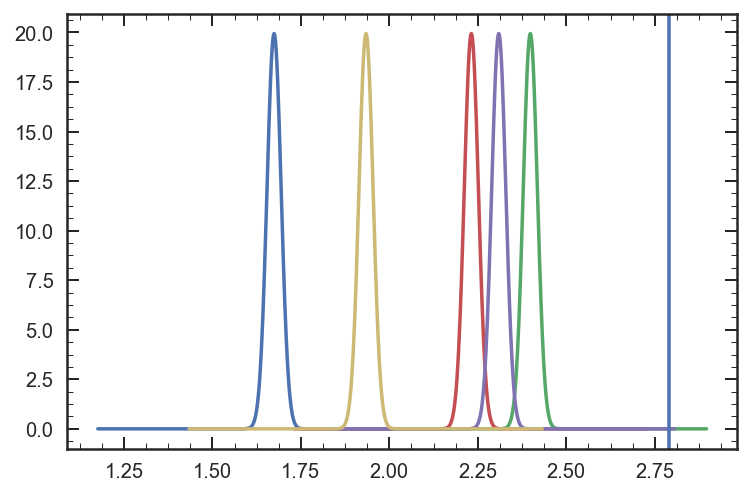

In [48]:
for i in range(5):
    plt.plot(LWA2[i], PLWA2[i])
plt.axvline(lwa2)

In [30]:
lages = [0,9.1,9.2,9.3,9.4,9.5,9.6,9.7,9.8,9.9,10]

lagebins = []

for i in range(len(lages)-1):
    lagebins.append([lages[i], lages[i+1]])

upd_lagebins = zred_to_agebins(zred=0.8, agebins=lagebins)

print((10**upd_lagebins.T[1][::-1][0] - 10**upd_lagebins.T[0][::-1])*1E-9)

[1.02474441 2.00793365 2.8246548  3.5030933  4.06666239 4.53481111
 4.92369552 5.2467362  5.57270398 6.83162939]


In [31]:
upd_lagebins

array([[0.        , 9.1       ],
       [9.1       , 9.2       ],
       [9.2       , 9.28056332],
       [9.28056332, 9.36112664],
       [9.36112664, 9.44168995],
       [9.44168995, 9.52225327],
       [9.52225327, 9.60281659],
       [9.60281659, 9.68337991],
       [9.68337991, 9.76394322],
       [9.76394322, 9.8345243 ]])